## Figures for the GRL 2023 paper

In this notebook, we use the `seistides` library, the tidal stresses near Ridgecrest, CA computed with SPOTL and the earthquake catalog from Beaucé et al. (2023) to reproduce their results and quantify the tidal modulation of microseismicity in the decade preceding the 2019 M7.1 Ridgecrest earthquake.

References
----------

- Beaucé, E., Poli, P., Waldhauser, F., Holtzman, B., & Scholz, C. (2023). Enhanced tidal sensitivity of seismicity before the 2019 magnitude 7.1 Ridgecrest, California earthquake. Geophysical Research Letters, 50(14), e2023GL104375.

- Agnew, D. C. (2012). SPOTL: Some programs for ocean-tide loading.

- Earlier versions of the earthquake catalog are available on Zenodo: https://zenodo.org/records/8393318

In [180]:
import os
import sys
os.environ["OPENBLAS_NUM_THREADS"] = "1"
sys.path.append(os.path.join(os.pardir, "seistides"))
sys.path.append(os.path.join(os.pardir, "data"))

import BPMF
import cartopy as ctp
import colorcet as cc
import copy
import h5py as h5
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as geopd
import seaborn as sns
from tqdm import tqdm
from dateutil.relativedelta import relativedelta
import string
# import from the seistides folder
import seistides
# import from the data folder
import utils_crosssection as utils_cs

from matplotlib.colors import Normalize, LogNorm
from matplotlib.cm import ScalarMappable
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from obspy import UTCDateTime as udt
from shapely import geometry
from scipy.signal import hilbert


sns.set(font_scale=1.3)
sns.set_style("ticks")
plt.rcParams["savefig.dpi"] = 200
plt.rcParams["svg.fonttype"] = "none"
plt.rcParams["patch.force_edgecolor"] = False
pd.set_option('display.width', 1000)

%config InlineBackend.figure_formats = ["svg"]

In [181]:
# I/O variables
PATH_DATA = "../data/"
TIDAL_STRESS_FILE = "tidal_stress.h5"

CAT_FILE = "catalog_BPMF_Ridgecrest_2009_2019_Beauce_et_al_2023.csv"
# do not hesitate checking out more recent versions (cleaner) of the catalog!!
# CAT_FILE = "catalog_BPMF_Ridgecrest_2009_2019_Beauce_et_al_v2-0-1.csv"

FAULT_FILENAME = "faults_SoCal.shp"
SURFACE_RUPTURE_FILENAME = "Surface_Rupture_Ridgecrest_Prov_Rel_1.shp"
PATH_PICKLED_INTERPOLATORS = "pickled_interpolators"
NETWORK_FILENAME = "../network/network.csv"

# program parameters
NBINS_STRESS = 50
NBINS_SEMIDIURNAL_PHASE = 100
N_BOOTSTRAPS = 100
COMPUTE_RATE = True

In [182]:
from obspy.geodetics.base import calc_vincenty_inverse
from cartopy.geodesic import Geodesic

G = Geodesic()

# define the box
LON_MIN_BOX, LAT_MIN_BOX = -117.740196, 35.907854
LON_MAX_BOX, LAT_MAX_BOX = -117.374174, 35.554416

dist, az, baz = calc_vincenty_inverse(
    LAT_MIN_BOX, LON_MIN_BOX, LAT_MAX_BOX, LON_MAX_BOX
)

# half width
ORTHOGONAL_DIST_KM = 2.5
# ORTHOGONAL_DIST_KM = 3.0
PARALLEL_DIST_KM = 0.0

if PARALLEL_DIST_KM != 0.0:
    LON_MIN_BOX, LAT_MIN_BOX, _ = np.asarray(
        G.direct([LON_MIN_BOX, LAT_MIN_BOX], baz, 1000.0 * PARALLEL_DIST_KM)
    ).squeeze()

    LON_MAX_BOX, LAT_MAX_BOX, _ = np.asarray(
        G.direct([LON_MAX_BOX, LAT_MAX_BOX], az, 1000.0 * -20.)
    ).squeeze()

cs_geometry = utils_cs.cross_section(
    LON_MIN_BOX, LAT_MIN_BOX, LON_MAX_BOX, LAT_MAX_BOX, ORTHOGONAL_DIST_KM
)


In [183]:
cs_geometry["corners"]

array([[-117.71906516,   35.92242052],
       [-117.35313636,   35.5689834 ],
       [-117.39520402,   35.53984489],
       [-117.76131909,   35.89328373]])

In [184]:
# faults = geopd.read_file(os.path.join(PATH_FAULTS, FAULT_FILENAME))
# surface_rupture = geopd.read_file(os.path.join(PATH_FAULTS, SURFACE_RUPTURE_FILENAME))

In [185]:
# map parameters
M71 = {"longitude": -117.599, "latitude": 35.770, "depth": 8.0}
M64 = {"longitude": -117.504, "latitude": 35.705, "depth": 10.5}

LON_MIN, LON_MAX = -117.8, -117.3
LAT_MIN, LAT_MAX = 35.50, 36.00
central_lon = (LON_MIN + LON_MAX) / 2.0
central_lat = (LAT_MIN + LAT_MAX) / 2.0

data_coords = ctp.crs.PlateCarree()
projection = ctp.crs.Mercator(
    central_longitude=central_lon, min_latitude=LAT_MIN, max_latitude=LAT_MAX
)

# define inset extent
LON_MIN_INSET, LON_MAX_INSET = -113.88, -126.00
LAT_MIN_INSET, LAT_MAX_INSET = 32.19, 42.63
central_lon_inset = (LON_MIN_INSET + LON_MAX_INSET) / 2.0
central_lat_inset = (LAT_MIN_INSET + LAT_MAX_INSET) / 2.0

projection_inset = ctp.crs.Mercator(
    central_longitude=central_lon_inset,
    min_latitude=LAT_MIN_INSET,
    max_latitude=LAT_MAX_INSET,
)

In [186]:
# define colormap
cnorm = Normalize(vmin=-2.0, vmax=20.0)
scalar_map = ScalarMappable(norm=cnorm, cmap=cc.cm.fire_r)

In [187]:
# net = BPMF.dataset.Network(NETWORK_FILENAME)
# net.read()

## Load Earthquake Catalog

In [188]:
cat = pd.read_csv(
    os.path.join(PATH_DATA, CAT_FILE),
    sep=",",
    # index_col=0,
)
cat["origin_time"] = pd.to_datetime(cat["origin_time"])
cat = cat[cat["origin_time"] < "2019-07-04"]
# cat = cat[cat["Ml"] > 0.]

cat["t_eq_s"] = cat["origin_time"].values.astype("datetime64[ms]").astype("float64")/1000.

cat_entire = cat.copy()
cat[["origin_time", "longitude", "latitude", "depth", "Mw", "event_id"]]

,origin_time,longitude,latitude,depth,Mw,event_id
0,2009-01-01 03:14:41.120,-117.386211,35.954063,19.862500,NaN,bp_20090101_031445
1,2009-01-01 05:44:45.660,-117.685918,35.747344,-0.006250,NaN,bp_20090101_054447
2,2009-01-01 07:25:33.620,-117.346572,35.930328,-1.965625,NaN,bp_20090101_072537
3,2009-01-01 15:50:51.060,-117.358174,35.931859,-1.965625,NaN,bp_20090101_155055
4,2009-01-01 20:16:29.140,-117.334004,35.949469,-1.931250,NaN,bp_20090101_201633
...,...,...,...,...,...,...
191564,2019-07-03 21:09:36.380,-117.781631,35.787922,-1.965625,NaN,bp_20190703_210939
191565,2019-07-03 23:00:27.040,-117.711055,35.905063,11.612500,NaN,tm_11995.172
191566,2019-07-03 23:11:38.660,-117.721689,35.898172,-0.934375,NaN,bp_20190703_231139
191567,2019-07-03 23:20:30.560,-117.423916,35.769547,-1.965625,NaN,tm_20639.13


In [189]:
geocat = geopd.GeoDataFrame(
    cat, geometry=geopd.points_from_xy(cat.longitude, cat.latitude)
)

selection = geocat.within(cs_geometry["box"])
cat = cat[selection]

print(f"There are {len(cat)} earthquakes in the requested box.")

There are 27406 earthquakes in the requested box.


In [190]:
# project earthquakes onto cross-section
cs_geometry["coords_cs"] = utils_cs.project_onto_cs(
        cs_geometry, cat["longitude"], cat["latitude"]
        )

## Load Tidal Stress

In [191]:
STRESS_FIELDS = [
    "shear_stress",
    "normal_stress",
    "coulomb_stress",
    "volumetric_strain"
]
PHASE_FIELDS = [
    f"instantaneous_phase_{stress}" for stress in ["shear", "normal", "coulomb", "volumetric"]
]

In [192]:
tidal_stress = seistides.load_tidal_stress(
    os.path.join(PATH_DATA, TIDAL_STRESS_FILE), fields=STRESS_FIELDS, rate=COMPUTE_RATE
    )
# convert strain to nanostrain
tidal_stress["volumetric_strain"] *= 1.e9
tidal_stress["volumetric_strain_rate"] *= 1.e9
# print(tidal_stress)
if COMPUTE_RATE:
    for field in list(STRESS_FIELDS):
        STRESS_FIELDS.append(f"{field}_rate")
print(STRESS_FIELDS)

['shear_stress', 'normal_stress', 'coulomb_stress', 'volumetric_strain', 'shear_stress_rate', 'normal_stress_rate', 'coulomb_stress_rate', 'volumetric_strain_rate']


In [193]:
# define the stress bins
STRESS_BINS = {}
for f in STRESS_FIELDS:
    STRESS_BINS[f"{f}_bins"] = np.linspace(
        np.percentile(tidal_stress[f], 5.0), np.percentile(tidal_stress[f], 95), NBINS_STRESS+1
    )
# define phase bins
PHASE_BINS = {}
for stress in ["shear", "normal", "coulomb", "volumetric"]:
    PHASE_BINS[f"instantaneous_phase_{stress}_bins"] = np.linspace(
        -180., +180., NBINS_SEMIDIURNAL_PHASE+1
    )

In [194]:
# approximate the semi-diurnal phase as the instantaneous phase
for stress in ["shear", "normal", "coulomb"]:
    analytical_signal = hilbert(tidal_stress[f"{stress}_stress"])
    _, tidal_stress[f"instantaneous_phase_{stress}"] = _, np.angle(analytical_signal, deg=True)
    # test unravelling phase
    unravelled_phase = seistides.unravel_phase(tidal_stress[f"instantaneous_phase_{stress}"].values)
    tidal_stress[f"unravelled_instantaneous_phase_{stress}"] = unravelled_phase

analytical_signal = hilbert(tidal_stress["volumetric_strain"])
_, tidal_stress["instantaneous_phase_volumetric"] = _, np.angle(analytical_signal, deg=True)
# test unravelling phase
unravelled_phase = seistides.unravel_phase(tidal_stress["instantaneous_phase_volumetric"].values)
tidal_stress["unravelled_instantaneous_phase_volumetric"] = unravelled_phase

In [195]:
seistides.compute_semidiurnal_phase_at_eq(cat, tidal_stress, PHASE_FIELDS)
seistides.compute_stress_at_eq(cat, tidal_stress, STRESS_FIELDS)

## Figure introduction

In [196]:
t_start = "2010-01-01"
t_end = "2010-02-01"
plotting = (tidal_stress.index >= t_start) & (tidal_stress.index < t_end)

/home/eric/miniconda3/envs/py310/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:406: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "


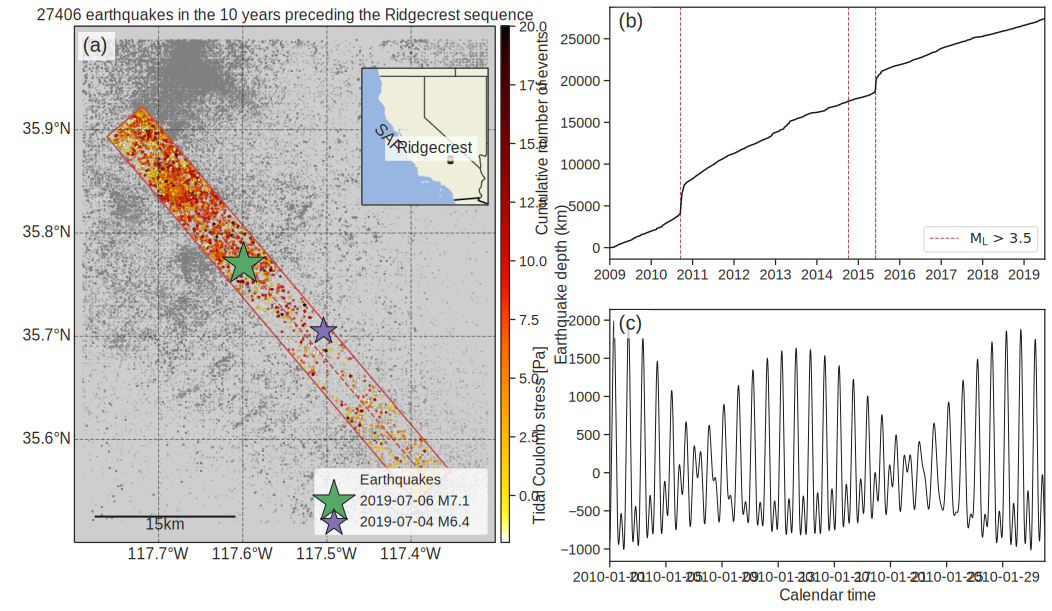

In [197]:
%matplotlib inline
fig = plt.figure("figure_introduction", figsize=(14.5, 10))
grid = fig.add_gridspec(nrows=4, ncols=4, hspace=0.5, wspace=0.6)

ax_map = fig.add_subplot(grid[:, :2], projection=projection)
ax_map.set_rasterization_zorder(1)
ax_map.set_extent([LON_MIN, LON_MAX, LAT_MIN, LAT_MAX], crs=data_coords)
ax_map = BPMF.plotting_utils.initialize_map(
    [LON_MIN, LON_MAX],
    [LAT_MIN, LAT_MAX],
    coastlines=False,
    oceans=False,
    map_axis=ax_map,
)

# add stations
# ax_map.scatter(
#     net.longitude,
#     net.latitude,
#     s=200,
#     color="magenta",
#     edgecolor="white",
#     marker="v",
#     label="Stations",
#     transform=data_coords,
# )

good_loc_entire = cat_entire["hmax_unc"] < 5.  
good_loc = cat["hmax_unc"] < 5. 

ax_map.scatter(
    cat_entire[~good_loc_entire]["longitude"],
    cat_entire[~good_loc_entire]["latitude"],
    s=0.2,
    color="dimgrey",
    alpha=0.33,
    zorder=2,
    marker="o",
    rasterized=True,
    transform=data_coords,
)
ax_map.scatter(
    cat_entire[good_loc_entire]["longitude"],
    cat_entire[good_loc_entire]["latitude"],
    s=0.4,
    color="grey",
    alpha=0.75,
    zorder=2,
    marker="o",
    rasterized=True,
    transform=data_coords,
)
ax_map.scatter(
    cat[good_loc]["longitude"],
    cat[good_loc]["latitude"],
    s=6,
    color=scalar_map.to_rgba(cat[good_loc]["depth"]),
    alpha=0.75,
    zorder=2,
    marker="o",
    edgecolor="k",
    linewidths=0.1,
    rasterized=True,
    transform=data_coords,
    label="Earthquakes"
)

BPMF.plotting_utils.add_scale_bar(ax_map, 0.05, 0.05, 15.0, projection)
ax_map.set_title(f"{len(cat)} earthquakes in the 10 years preceding the Ridgecrest sequence")
# ax_map.add_geometries(
#     faults["geometry"], crs=data_coords, facecolor="none", edgecolor="k", zorder=2, rasterized=True
# )
# ax_map.add_geometries(
#     surface_rupture["geometry"],
#     crs=data_coords,
#     facecolor="none",
#     edgecolor="w",
#     linewidth=5,
#     rasterized=True,
#     zorder=1.8,
# )
# ax_map.add_geometries(
#     surface_rupture["geometry"],
#     crs=data_coords,
#     facecolor="none",
#     edgecolor="k",
#     linewidth=2.5,
#     rasterized=True,
#     zorder=1.9,
# )

# add Ridgecrest earthquake and the M6.4 foreshock
ax_map.scatter(
    M71["longitude"],
    M71["latitude"],
    marker="*",
    s=2000,
    edgecolors="k",
    color="C2",
    transform=data_coords,
    zorder=2.1,
    label="2019-07-06 M7.1",
)
ax_map.scatter(
    M64["longitude"],
    M64["latitude"],
    marker="*",
    s=800,
    edgecolors="k",
    color="C4",
    transform=data_coords,
    zorder=2.1,
    label="2019-07-04 M6.4",
)

# plot inset map
axins = inset_axes(
    ax_map,
    width="30%",
    height="40%",
    loc="upper right",
    axes_class=ctp.mpl.geoaxes.GeoAxes,
    axes_kwargs=dict(map_projection=projection_inset),
)
axins.set_extent(
    [LON_MIN_INSET, LON_MAX_INSET, LAT_MIN_INSET, LAT_MAX_INSET],
    crs=data_coords,
)
study_region = geometry.box(
    minx=LON_MIN, maxx=LON_MAX, miny=LAT_MIN, maxy=LAT_MAX
)
axins.add_geometries(
    [study_region], crs=data_coords, edgecolor="k", facecolor="C3"
)
axins.set_rasterization_zorder(1.5)
axins.add_feature(ctp.feature.LAND)
axins.add_feature(ctp.feature.OCEAN)
axins.text(
    central_lon + 2.2,
    central_lat + 1.5,
    "Ridgecrest",
    ha="right",
    va="top",
    transform=data_coords,
    bbox={"facecolor": "white", "alpha": 0.75},
)
axins.text(
    -125.1,
    38.7,
    "SAF",
    ha="left",
    va="top",
    rotation=-47,
    transform=data_coords,
    # bbox={"facecolor": "white", "alpha": 0.75}
)
# fault_sel = faults["Name"] == "San Andreas fault zone"
# axins.add_geometries(
#     faults[fault_sel]["geometry"],
#     crs=data_coords,
#     facecolor="none",
#     edgecolor="k",
#     zorder=2,
#     rasterized=True,
# )
# add country and state borders
axins.add_feature(ctp.feature.BORDERS, lw=1.5)

scale = "110m"
states110 = ctp.feature.NaturalEarthFeature(
    category="cultural",
    name="admin_1_states_provinces_lines",
    scale=scale,
    facecolor="none",
    edgecolor="k",
)
axins.add_feature(states110, lw=1.0, zorder=0.5)

box_lon = np.hstack((cs_geometry["corners"][:, 0], cs_geometry["corners"][0, 0]))
box_lat = np.hstack((cs_geometry["corners"][:, 1], cs_geometry["corners"][0, 1]))
ax_map.plot(box_lon, box_lat, transform=data_coords, color="C3")
ax_map.plot(
    [cs_geometry["lon1"], cs_geometry["lon2"]],
    [cs_geometry["lat1"], cs_geometry["lat2"]],
    color="C3",
    ls="--",
    transform=data_coords,
    )

# add color bar
divider = make_axes_locatable(ax_map)
cax = divider.append_axes("right", size="2%", pad=0.08, axes_class=plt.Axes)
plt.colorbar(scalar_map, cax=cax, label="Earthquake depth (km)")

ax_cumul = fig.add_subplot(grid[:2, 2:])
ax_cumul.plot(cat["origin_time"], np.arange(len(cat)), color="k")
ax_cumul.set_ylabel("Cumulative number of events")

large_eq = cat[cat["Ml"] > 3.5]

ax_cumul.set_xlim(pd.Timestamp("2009-01-01"), pd.Timestamp("2019-07-03"))
for i in range(len(large_eq)):
    if i == 0:
        label = r"$M_{L}$ > 3.5"
    else:
        label = ""
    ax_cumul.axvline(large_eq.iloc[i]["origin_time"], color="C3", zorder=0., lw=1.0, ls="--", label=label)

ax_tides = fig.add_subplot(grid[2:, 2:])
ax_tides.plot(
    tidal_stress.index[plotting],
    tidal_stress["coulomb_stress"][plotting],
    color="k",
    lw=1,
)
ax_tides.set_xlabel("Calendar time")
ax_tides.set_ylabel("Tidal Coulomb stress [Pa]")
ax_tides.set_xlim(tidal_stress.index[plotting].min(), tidal_stress.index[plotting].max())

ax_map.set_facecolor("dimgrey")
ax_map.patch.set_alpha(0.33)

ax_map.legend(loc="lower right")
ax_cumul.legend(loc="lower right")

for i, ax in enumerate([ax_map, ax_cumul, ax_tides]):
    ax.text(0.02, 0.98, f'({string.ascii_lowercase[i]})', va='top',
            fontsize=20, ha='left', bbox={"facecolor": "white", "alpha": 0.75}, transform=ax.transAxes)   

fig.set_facecolor("white")

plt.subplots_adjust(right=0.98, left=0.05)


In [198]:
# fig.savefig(fig._label + ".svg", format="svg", bbox_inches="tight", dpi=250)

## Methodology figure

In [199]:
# sliding window parameters
SHORT_WINDOW_DAYS = 3 * 30
OVERLAP = 0.90
N_SHORT_WINDOWS = 128
LARGE_WINDOW_DAYS = (
    N_SHORT_WINDOWS * (1.0 - OVERLAP) * SHORT_WINDOW_DAYS + OVERLAP * SHORT_WINDOW_DAYS
)
LARGE_WINDOW_SHIFT = relativedelta(months=3)
WINDOW_DURATION = pd.Timedelta(days=LARGE_WINDOW_DAYS)

DOWNSAMPLE_STRESS = 2
DOWNSAMPLE_PHASE = 2

short_window_dur = relativedelta(days=SHORT_WINDOW_DAYS)
short_window_shift = relativedelta(days=int((1.0 - OVERLAP) * SHORT_WINDOW_DAYS))

t_end = pd.Timestamp("2019-07-03")
t_start = t_end - short_window_dur
for i in range(N_SHORT_WINDOWS-1):
    t_start -= short_window_shift
print(t_start, t_end)

subcat = cat[(cat["origin_time"] > t_start) & (cat["origin_time"] <= t_end)]
subtidal_stress = tidal_stress[(tidal_stress.index > t_start) & (tidal_stress.index <= t_end)]

nth_window = 64
shift1 = nth_window*short_window_shift
shift0 = shift1 - short_window_shift
subcat1 = cat[(cat["origin_time"] > t_end-short_window_dur-short_window_shift) & (cat["origin_time"] <= t_end)]
subcat2 = cat[(cat["origin_time"] > t_end-short_window_dur-shift1) & (cat["origin_time"] <= t_end-shift1)]

subtidal_stress1 = tidal_stress[(tidal_stress.index > t_end-short_window_dur-short_window_shift) & (tidal_stress.index <= t_end)]
subtidal_stress2 = tidal_stress[(tidal_stress.index > t_end-short_window_dur-shift1) & (tidal_stress.index <= t_end-shift0)]

2016-06-22 00:00:00 2019-07-03 00:00:00


In [200]:
stress_shortwin1 = seistides.bin_eq_tidal_stresses(
    subcat1, subtidal_stress1, stress_bins=STRESS_BINS, fields=STRESS_FIELDS,
)
stress_shortwin2 = seistides.bin_eq_tidal_stresses(
    subcat2, subtidal_stress1, stress_bins=STRESS_BINS, fields=STRESS_FIELDS,
)

phase_shortwin1 = seistides.bin_eq_tidal_phases(
    subcat1, subtidal_stress1, phase_bins=PHASE_BINS, fields=PHASE_FIELDS,
)
phase_shortwin2 = seistides.bin_eq_tidal_phases(
    subcat2, subtidal_stress1, phase_bins=PHASE_BINS, fields=PHASE_FIELDS,
)

In [201]:
stress_largewin = seistides.composite_rate_ratio_vs_stress(
    subcat,
    subtidal_stress,
    nbins=NBINS_STRESS,
    short_window_days=SHORT_WINDOW_DAYS,
    n_short_windows=N_SHORT_WINDOWS,
    overlap=OVERLAP,
    stress_bins=STRESS_BINS,
    fields=STRESS_FIELDS,
    downsample=DOWNSAMPLE_STRESS,
    t_end=t_end
)

phase_largewin = seistides.composite_rate_ratio_vs_phase(
    subcat,
    subtidal_stress,
    short_window_days=SHORT_WINDOW_DAYS,
    n_short_windows=N_SHORT_WINDOWS,
    overlap=OVERLAP,
    phase_bins=PHASE_BINS,
    fields=PHASE_FIELDS,
    downsample=DOWNSAMPLE_PHASE,
    t_end=t_end,
)

Computing in sub-windows: 100%|██████████| 128/128 [00:00<00:00, 164.57it/s]


In [202]:
stress_type = "coulomb"
stress_field = f"{stress_type}_stress"
phase_field = f"instantaneous_phase_{stress_type}"

stress_binh_width = (
    stress_shortwin1[stress_field]["stress_bins"][1]
    - stress_shortwin1[stress_field]["stress_bins"][0]
)
stress_bin_width = (
    stress_largewin[stress_field]["stress_bins"][1]
    - stress_largewin[stress_field]["stress_bins"][0]
)
stress_barhplot_params = {"edgecolor": "none", "color": "C3", "align": "edge"}
stress_barplot_params = {"edgecolor": "none", "color": "C3", "align": "edge"}

phase_binh_width = (
    phase_shortwin1[phase_field]["phase_bins"][1]
    - phase_shortwin1[phase_field]["phase_bins"][0]
)
phase_bin_width = (
    phase_largewin[phase_field]["phase_bins"][1]
    - phase_largewin[phase_field]["phase_bins"][0]
)
phase_barhplot_params = {"edgecolor": "none", "color": "C0", "align": "edge"}
phase_barplot_params = {"edgecolor": "none", "color": "C0", "align": "edge"}

In [203]:
# fit stress
# linear "model"
intercept, slope, intercept_err, slope_err = seistides.fit_stress_hist_scipy(
    stress_largewin[stress_field]["stress_bins"][:-1] + stress_bin_width,
    stress_largewin[stress_field]["rate_ratio"],
    stress_largewin[stress_field]["rate_ratio_err"],
)
linear_fit_stress = intercept + slope * (stress_largewin[stress_field]["stress_bins"][:-1] + stress_bin_width)
# rate-state model
Asig_Pa, Asig_Pa_err = seistides.fit_rate_state_bootstrap(
    stress_largewin[stress_field]["stress_bins"][:-1] + stress_bin_width,
    stress_largewin[stress_field]["rate_ratio"],
    stress_largewin[stress_field]["rate_ratio_err"],
)
rate_state_fit_stress = seistides.rate_state(
    stress_largewin[stress_field]["stress_bins"][:-1] + stress_bin_width, Asig_Pa
    )

# fit stress phase
alpha, phi, alpha_err, phi_err = seistides.fit_semidiurnal_triggering_bootstrap(
    phase_largewin[phase_field]["phase_bins"][:-1] + phase_bin_width,
    phase_largewin[phase_field]["rate_ratio"],
    phase_largewin[phase_field]["rate_ratio_err"],
    n_bootstrap=100,
    objective="negative-log-likelihood"
)
cos_fit_phase = 1.0 + seistides.cos(np.deg2rad(phase_largewin[phase_field]["phase_bins"][:-1] + phase_bin_width), alpha, phi)

/home/eric/software/seistides/notebooks/../seistides/seistides.py:1074: RuntimeWarning: divide by zero encountered in log
  loss = lambda p, obs: -np.sum(obs * np.log(1. + p[0] * np.cos(x_ - p[1])))
/home/eric/miniconda3/envs/py310/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


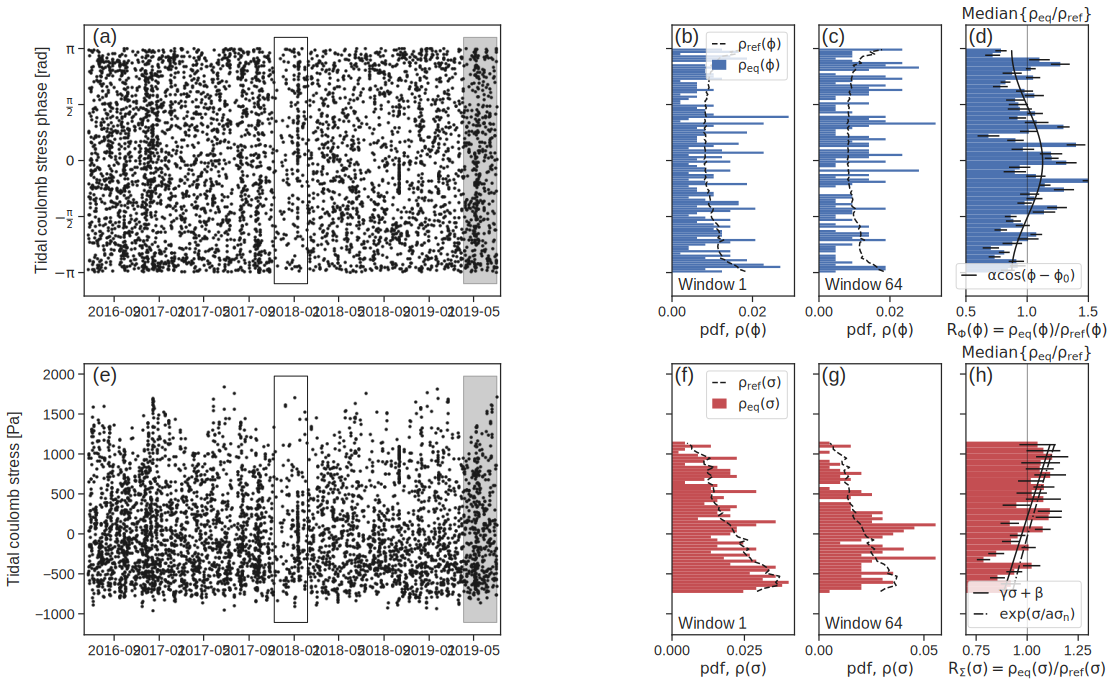

In [204]:
fig = plt.figure("tidal_triggering_methodology", figsize=(18, 11))

gs = fig.add_gridspec(nrows=2, ncols=7)

mid_bins_short_stress = (
        stress_shortwin1[stress_field]["stress_bins"][1:]
        + stress_shortwin1[stress_field]["stress_bins"][:-1]
    ) / 2.0
mid_bins_short_phase = (
        phase_shortwin1[phase_field]["phase_bins"][1:]
        + phase_shortwin1[phase_field]["phase_bins"][:-1]
    ) / 2.0
mid_bins_large_stress = (
        stress_largewin[stress_field]["stress_bins"][1:]
        + stress_largewin[stress_field]["stress_bins"][:-1]
    ) / 2.0
mid_bins_large_phase = (
        phase_largewin[phase_field]["phase_bins"][1:]
        + phase_largewin[phase_field]["phase_bins"][:-1]
    ) / 2.0

ax1 = fig.add_subplot(gs[0, :3])
ax1.scatter(
    subcat["origin_time"],
    subcat[phase_field],
    marker="o",
    color="k",
    s=5,
    rasterized=True,
)
ax1.set_ylabel(f"Tidal {stress_field.replace('_', ' ')} phase [rad]")
bottom, top = ax1.get_ylim()
ax1.fill_between(
    [t_end - short_window_dur, t_end],
    bottom,
    top,
    zorder=0.0,
    color="dimgrey",
    alpha=0.33,
    edgecolor="k",
)
ax1.fill_between(
    [t_end - short_window_dur - shift1, t_end - short_window_shift - shift0],
    bottom,
    top,
    zorder=0.0,
    color="dimgrey",
    edgecolor="k",
    facecolor="none",
)

ax2 = fig.add_subplot(gs[1, :3])
ax2.scatter(
    subcat["origin_time"],
    subcat[stress_field],
    marker="o",
    color="k",
    s=5,
    rasterized=True,
)
ax2.set_ylabel(f"Tidal {stress_field.replace('_', ' ')} [Pa]")
bottom, top = ax2.get_ylim()
ax2.fill_between(
    [t_end - short_window_dur, t_end],
    bottom,
    top,
    zorder=0.0,
    color="dimgrey",
    alpha=0.33,
    edgecolor="k",
)
ax2.fill_between(
    [t_end - short_window_dur - shift1, t_end - short_window_shift - shift0],
    bottom,
    top,
    zorder=0.0,
    color="dimgrey",
    edgecolor="k",
    facecolor="none",
)

ax5 = fig.add_subplot(gs[1, -3], sharey=ax2)
ax5.barh(
    stress_shortwin1[stress_field]["stress_bins"][:-1],
    stress_shortwin1[stress_field]["observed_rate"],
    height=stress_binh_width,
    **stress_barhplot_params,
    label=r"$\rho_{eq}(\sigma)$",
)
ax5.plot(
    stress_shortwin1[stress_field]["expected_rate"],
    mid_bins_short_stress,
    ls="--",
    # marker=".",
    color="k",
    label=r"$\rho_{ref}(\sigma)$",
)
ax6 = fig.add_subplot(gs[1, -2], sharey=ax2)
ax6.barh(
    stress_shortwin2[stress_field]["stress_bins"][:-1],
    stress_shortwin2[stress_field]["observed_rate"],
    height=stress_binh_width,
    **stress_barhplot_params,
)
ax6.plot(
    stress_shortwin2[stress_field]["expected_rate"],
    mid_bins_short_stress,
    ls="--",
    # marker=".",
    color="k",
)

ax3 = fig.add_subplot(gs[0, -3], sharey=ax1)
ax3.barh(
    phase_shortwin1[phase_field]["phase_bins"][:-1],
    phase_shortwin1[phase_field]["observed_rate"],
    height=phase_binh_width,
    **phase_barhplot_params,
    label=r"$\rho_{eq}(\phi)$",
)
ax3.plot(
    phase_shortwin1[phase_field]["expected_rate"],
    mid_bins_short_phase,
    ls="--",
    # marker=".",
    color="k",
    label=r"$\rho_{ref}(\phi)$",
)
# ratio = phase_shortwin1[phase_field]["pdf"]/phase_shortwin1[phase_field]["fraction_expected"]
# ax3.plot(
#     ratio/ratio.sum(),
#     mid_bins_short_phase,
#     # marker=".",
#     color="k",
#     label=r"$\rho_{\tau_{eq}}(\phi)/\rho_{\tau}(\phi)$",
# )
ax4 = fig.add_subplot(gs[0, -2], sharey=ax1)
ax4.barh(
    phase_shortwin2[phase_field]["phase_bins"][:-1],
    phase_shortwin2[phase_field]["observed_rate"],
    height=phase_binh_width,
    **phase_barhplot_params,
)
ax4.plot(
    phase_shortwin2[phase_field]["expected_rate"],
    mid_bins_short_phase,
    ls="--",
    # marker=".",
    color="k",
)

ax8 = fig.add_subplot(gs[1, -1], sharey=ax2)
ax8.barh(
    stress_largewin[stress_field]["stress_bins"][:-1],
    stress_largewin[stress_field]["rate_ratio"],
    xerr=stress_largewin[stress_field]["rate_ratio_err"],
    height=stress_bin_width,
    **stress_barhplot_params,
)
ax8.axvline(1.0, lw=0.50, color="k")

ax7 = fig.add_subplot(gs[0, -1], sharey=ax1)
ax7.barh(
    phase_largewin[phase_field]["phase_bins"][:-1],
    phase_largewin[phase_field]["rate_ratio"],
    xerr=phase_largewin[phase_field]["rate_ratio_err"],
    height=phase_bin_width,
    **phase_barhplot_params,
)
ax7.axvline(1.0, lw=0.50, color="k")

# plot fits
ax7.plot(
    cos_fit_phase,
    mid_bins_large_phase,
    color="k",
    label=r"$\alpha \cos (\phi - \phi_0)$"
)
ax8.plot(
    linear_fit_stress,
    mid_bins_large_stress,
    color="k",
    label=r"$\gamma \sigma + \beta$",
)
ax8.plot(
    rate_state_fit_stress,
    mid_bins_large_stress,
    color="k",
    ls="-.",
    label=r"$\exp(\sigma/a \sigma_n)$",
)

for ax in [ax3, ax4, ax5, ax6, ax7, ax8]:
    plt.setp(ax.get_yticklabels(), visible=False)
for ax in [ax3, ax5]:
    ax.text(0.05, 0.01, "Window 1", ha="left", va="bottom", transform=ax.transAxes)
for ax in [ax4, ax6]:
    ax.text(0.05, 0.01, f"Window {nth_window}", ha="left", va="bottom", transform=ax.transAxes)
for ax in [ax3, ax4]:
    ax.set_xlabel(r"pdf, $\rho(\phi)$")  
for ax in [ax5, ax6]:
    ax.set_xlabel(r"pdf, $\rho(\sigma)$")


ax8.set_xlabel(r"$R_\Sigma(\sigma) = \rho_{eq}(\sigma)/\rho_{ref}(\sigma)$")
ax7.set_xlabel(r"$R_\Phi(\phi) = \rho_{eq}(\phi)/\rho_{ref}(\phi)$")
ax7.set_xlim(0.5, 1.5)
ax8.set_xlim(0.7, 1.3)

ytick_loc = [-180.0, -90.0, 0, 90.0, 180.0]
ytick_lab = [r"$-\pi$", r"$-\frac{\pi}{2}$", r"$0$", r"$\frac{\pi}{2}$", r"$\pi$"]
for i, ax in enumerate([ax1, ax3, ax4, ax7]):
    ax.set_yticks(ytick_loc)
    if i == 0:
        ax.set_yticklabels(ytick_lab)

for ax in [ax3, ax5]:
    ax.legend(loc="upper right", handlelength=1)
for ax in [ax7, ax8]:
    ax.legend(loc="lower right", handlelength=1)
    ax.set_title(r"Median$\lbrace \rho_{eq}/\rho_{ref} \rbrace$")

for ax in [ax1, ax2]:
    ax.set_xlim(t_start - relativedelta(days=10.0), t_end + relativedelta(days=10.0))

for i, ax in enumerate([ax1, ax3, ax4, ax7, ax2, ax5, ax6, ax8]):
    ax.text(
        0.02,
        0.99,
        f"({string.ascii_lowercase[i]})",
        va="top",
        fontsize=20,
        ha="left",
        transform=ax.transAxes,
    )

plt.subplots_adjust(
    hspace=0.25
)

In [205]:
# fig.savefig(fig._label + ".svg", format="svg", bbox_inches="tight", dpi=250)

## Spatio-temporal Distribution

In [206]:
SHORT_WINDOW_DAYS = 3*30
OVERLAP = 0.90
N_SHORT_WINDOWS = 128
LARGE_WINDOW_SHIFT = relativedelta(years=2)
DOWNSAMPLE = 2
large_window_dur = N_SHORT_WINDOWS*(1.-OVERLAP)*SHORT_WINDOW_DAYS + OVERLAP*SHORT_WINDOW_DAYS

window_duration = pd.Timedelta(days=large_window_dur)
t_end = pd.Timestamp("2019-07-03")
t_start = t_end - window_duration

subcats = {}
while t_start > pd.Timestamp("2009-01-01"):
    print(t_start.strftime("%Y-%m-%d"), "-", t_end.strftime("%Y-%m-%d"))
    # subcats[t_end.strftime("%Y-%m-%d")] = cat[(cat["origin_time"] > t_start) & (cat["origin_time"] < t_end)]
    # subcats[t_end.strftime("%Y-%m-%d")] = cat_entire[(cat_entire["origin_time"] > t_start) & (cat_entire["origin_time"] < t_end)]
    subcats[t_end.strftime("%Y-%m-%d")] = cat_entire[
        (cat_entire["origin_time"] > t_start) & (cat_entire["origin_time"] < t_end) & (cat_entire["latitude"] < 35.90)
        ]
    t_start -= LARGE_WINDOW_SHIFT
    t_end -= LARGE_WINDOW_SHIFT

2016-02-16 - 2019-07-03
2014-02-16 - 2017-07-03
2012-02-16 - 2015-07-03
2010-02-16 - 2013-07-03


In [207]:
# from scipy.stats import gaussian_kde

# fig, axes = plt.subplots(num="space_time_distribution", ncols=len(subcats), subplot_kw={"projection": projection}, figsize=(16, 10))
# plt.subplots_adjust(left=0.08, right=0.98, wspace=0.05)
# time_periods = list(subcats.keys())
# time_periods.sort()

# for i, ax in enumerate(axes):
#     subcat = subcats[time_periods[i]]
#     # ax_map.set_rasterization_zorder(1)
#     ax.set_extent([LON_MIN, LON_MAX, LAT_MIN, LAT_MAX], crs=data_coords)
#     left_labels = True if i == 0 else False
#     ax = BPMF.plotting_utils.initialize_map(
#         [LON_MIN, LON_MAX],
#         [LAT_MIN, LAT_MAX],
#         coastlines=False,
#         oceans=True,
#         map_axis=ax,
#         left_labels=left_labels,
#     )

#     projected_xy = ax.projection.transform_points(
#         data_coords, subcat["longitude"], subcat["latitude"]
#     )
#     x, y = projected_xy[:, 0], projected_xy[:, 1]
#     sns.kdeplot(
#                 x=x, y=y, ax=ax, fill=True, cmap="Blues", zorder=2.5, alpha=0.85, norm=LogNorm()
#             )
#     # median_lon = np.median(subcat["longitude"])
#     # median_lat = np.median(subcat["latitude"])
#     # ax.plot(
#     #     median_lon, median_lat, ls="", marker="s", markeredgecolor="k",
#     #     color="magenta", markeredgewidth=1., transform=data_coords, zorder=3.,
#     #     label="Median Earthquake Location"
#     #     )
#     if i == 0:
#         ax.legend(loc="upper right")


#     BPMF.plotting_utils.add_scale_bar(ax, 0.05, 0.05, 15.0, projection)
#     ax.set_title(f"{subcat['origin_time'].min().strftime('%Y-%m-%d')} - {time_periods[i]}")
#     # ax.add_geometries(
#     #     faults["geometry"], crs=data_coords, facecolor="none", edgecolor="k", zorder=2, rasterized=True
#     # )
#     # ax.add_geometries(
#     #     surface_rupture["geometry"],
#     #     crs=data_coords,
#     #     facecolor="none",
#     #     edgecolor="k",
#     #     linewidth=2,
#     #     rasterized=True,
#     #     zorder=1.9,
#     # )

#     # add Ridgecrest earthquake and the M6.4 foreshock
#     ax.scatter(
#         M71["longitude"],
#         M71["latitude"],
#         marker="*",
#         s=500,
#         edgecolors="k",
#         color="C2",
#         transform=data_coords,
#         zorder=2.7,
#         label="2019-07-06 M7.1",
#     )
#     ax.scatter(
#         M64["longitude"],
#         M64["latitude"],
#         marker="*",
#         s=200,
#         edgecolors="k",
#         color="C4",
#         transform=data_coords,
#         zorder=2.7,
#         label="2019-07-04 M6.4",
#     )

#     ax.set_facecolor("dimgrey")
#     ax.patch.set_alpha(0.33)

# fig.set_facecolor("w")

In [208]:
# fig.savefig(fig._label + ".svg", format="svg", bbox_inches="tight", dpi=250)

## Continuous analysis: Instantaneous Coulomb phase

In [209]:
fortnightly_phase = FORTNIGHTLY_PHASES[2]
SHORT_WINDOW_DAYS = 3 * 30
OVERLAP = 0.90
N_SHORT_WINDOWS = 128
# N_SHORT_WINDOWS = 64
large_window_dur = N_SHORT_WINDOWS*(1.-OVERLAP)*SHORT_WINDOW_DAYS + OVERLAP*SHORT_WINDOW_DAYS
print(f"Large window duration: {large_window_dur}")
LARGE_WINDOW_SHIFT = relativedelta(months=3)

window_duration = pd.Timedelta(days=large_window_dur)
print(window_duration)

PHASE_FIELDS = ["instantaneous_phase_shear", "instantaneous_phase_normal", "instantaneous_phase_coulomb"]

DOWNSAMPLE = 2

t_end = pd.Timestamp("2019-07-03")
# t_end = pd.Timestamp("2018-01-01")
t_start = t_end - window_duration
seismicity_vs_phase_continuous = {}
median_depth = {}
depths = {}
selection_masks = []

while t_end-window_duration > pd.Timestamp("2009-01-01"):
    print(t_start.strftime("%Y-%m-%d"), "-", t_end.strftime("%Y-%m-%d"))
    seismicity_vs_phase_continuous[
        t_end.strftime("%Y-%m-%d")
    ] = seistides.composite_rate_ratio_vs_phase(
        cat,
        tidal_stress,
        short_window_days=SHORT_WINDOW_DAYS,
        n_short_windows=N_SHORT_WINDOWS,
        overlap=OVERLAP,
        t_end=t_end,
        progress=False,        
        phase_bins=PHASE_BINS,
        fields=PHASE_FIELDS,
        downsample=DOWNSAMPLE,
    )
    selection_masks.append((cat["origin_time"] > t_start) & (cat["origin_time"] < t_end))
    subcat = cat[(cat["origin_time"] > t_start) & (cat["origin_time"] < t_end)]
    median_depth[t_end.strftime("%Y-%m-%d")] = np.median(subcat["depth"])
    depths[t_end.strftime("%Y-%m-%d")] = subcat["depth"]
    # fit ratio
    phase_midbins = (
        seismicity_vs_phase_continuous[t_end.strftime("%Y-%m-%d")][PHASE_FIELDS[0]][
            "phase_bins"
        ][1:]
        + seismicity_vs_phase_continuous[t_end.strftime("%Y-%m-%d")][
            PHASE_FIELDS[0]
        ]["phase_bins"][:-1]
    ) / 2.0
    for field in PHASE_FIELDS:
        alpha, phi, alpha_err, phi_err = seistides.fit_semidiurnal_triggering_bootstrap(
            phase_midbins,
            seismicity_vs_phase_continuous[t_end.strftime("%Y-%m-%d")][field][
                "rate_ratio"
            ],
            seismicity_vs_phase_continuous[t_end.strftime("%Y-%m-%d")][field][
                "rate_ratio_err"
            ],
            n_bootstrap=100,
            objective="negative-log-likelihood",
            # objective="l2"
        )
        seismicity_vs_phase_continuous[t_end.strftime("%Y-%m-%d")][field][
            "alpha"
        ] = alpha
        seismicity_vs_phase_continuous[t_end.strftime("%Y-%m-%d")][field][
            "phi"
        ] = phi
        seismicity_vs_phase_continuous[t_end.strftime("%Y-%m-%d")][field][
            "alpha_err"
        ] = alpha_err
        seismicity_vs_phase_continuous[t_end.strftime("%Y-%m-%d")][field][
            "phi_err"
        ] = phi_err
    t_start -= LARGE_WINDOW_SHIFT
    t_end -= LARGE_WINDOW_SHIFT


Large window duration: 1232.9999999999998
1232 days 23:59:59.999999968
2016-02-16 - 2019-07-03
2015-11-16 - 2019-04-03
2015-08-16 - 2019-01-03
2015-05-16 - 2018-10-03
2015-02-16 - 2018-07-03
2014-11-16 - 2018-04-03
2014-08-16 - 2018-01-03
2014-05-16 - 2017-10-03
2014-02-16 - 2017-07-03
2013-11-16 - 2017-04-03
2013-08-16 - 2017-01-03
2013-05-16 - 2016-10-03
2013-02-16 - 2016-07-03
2012-11-16 - 2016-04-03
2012-08-16 - 2016-01-03
2012-05-16 - 2015-10-03
2012-02-16 - 2015-07-03
2011-11-16 - 2015-04-03
2011-08-16 - 2015-01-03
2011-05-16 - 2014-10-03
2011-02-16 - 2014-07-03
2010-11-16 - 2014-04-03
2010-08-16 - 2014-01-03
2010-05-16 - 2013-10-03
2010-02-16 - 2013-07-03
2009-11-16 - 2013-04-03
2009-08-16 - 2013-01-03
2009-05-16 - 2012-10-03
2009-02-16 - 2012-07-03


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


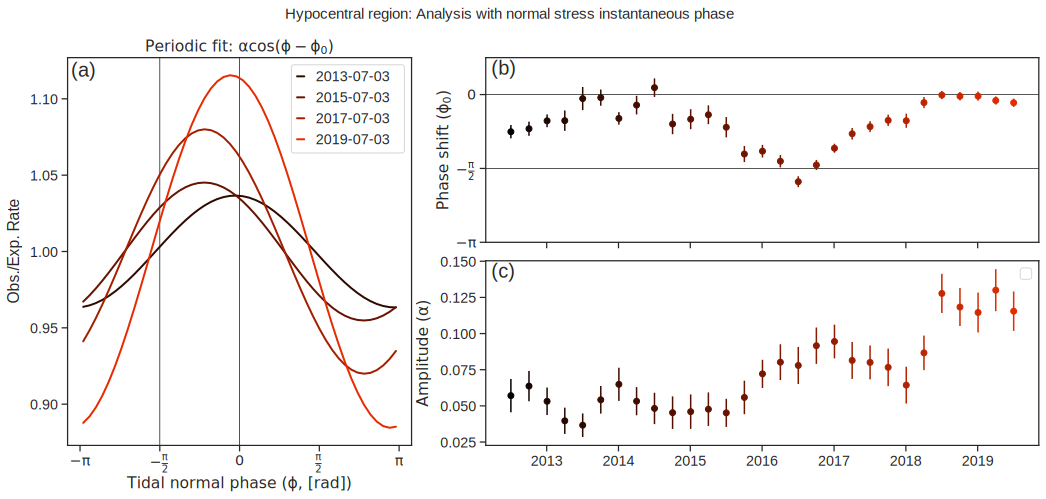

In [210]:
fig = plt.figure("instantaneous_phase", figsize=(15, 7))
gs = fig.add_gridspec(nrows=2, ncols=5)

stress_type = "normal"

fig.suptitle(
    f"Hypocentral region: Analysis with {stress_type} stress instantaneous phase",#\n(median across {N_SHORT_WINDOWS} windows, float32, incorrect shear sign)",
    fontsize=15
    )

plt.subplots_adjust(hspace=0.10, right=0.99, top=0.88, left=0.09, wspace=0.55)

time_periods = list(seismicity_vs_phase_continuous.keys())
time_periods.sort()
time_plot = pd.to_datetime(time_periods)

# color map for time stress
cnorm = Normalize(
    vmin=pd.Timestamp(time_periods[0]).timestamp(),
    vmax=pd.Timestamp(time_periods[-1]).timestamp(),
)
scalar_map = ScalarMappable(cmap=cc.cm.kr, norm=cnorm)

tick_loc = [-180.0, -90.0, 0, 90.0, 180.0]
tick_lab = [r"$-\pi$", r"$-\frac{\pi}{2}$", r"$0$", r"$\frac{\pi}{2}$", r"$\pi$"]

field = f"instantaneous_phase_{stress_type}"

phase_midbins = (
    seismicity_vs_phase_continuous[time_periods[0]][field]["phase_bins"][1:]
    + seismicity_vs_phase_continuous[time_periods[0]][field]["phase_bins"][:-1]
) / 2.0

phase_fit = np.zeros((len(time_periods), len(phase_midbins)), dtype=np.float32)
alpha = np.zeros(len(time_periods), dtype=np.float32)
alpha_err = np.zeros(len(time_periods), dtype=np.float32)
phi = np.zeros(len(time_periods), dtype=np.float32)
phi_err = np.zeros(len(time_periods), dtype=np.float32)
for t, tp in enumerate(time_periods):
    alpha[t] = seismicity_vs_phase_continuous[tp][field]["alpha"]
    alpha_err[t] = seismicity_vs_phase_continuous[tp][field]["alpha_err"]
    phi[t] = seismicity_vs_phase_continuous[tp][field]["phi"]
    phi_err[t] = seismicity_vs_phase_continuous[tp][field]["phi_err"]
    phase_fit[t, :] = seistides.cos(
        np.deg2rad(phase_midbins),
        seismicity_vs_phase_continuous[tp][field]["alpha"],
        seismicity_vs_phase_continuous[tp][field]["phi"],
    )

ax1 = fig.add_subplot(gs[:, :2])
ax2 = fig.add_subplot(gs[0, 2:])
ax3 = fig.add_subplot(gs[1, 2:], sharex=ax2)

inc = 1.0
plot_times = ["2013-07-03", "2015-07-03", "2017-07-03", "2019-07-03"]
for tp in plot_times:
    t = time_periods.index(tp)
    time = pd.Timestamp(tp)
    color = scalar_map.to_rgba(time.timestamp())
    ax1.plot(
        phase_midbins,
        inc + phase_fit[t, :],
        color=color,
        lw=2,
        label=time.strftime("%Y-%m-%d"),
    )
    # inc += 0.05
    # ax1.axvline(np.rad2deg(phi[t]), color=color)
    # ax2.errorbar(
    #     time,
    #     np.rad2deg(phi[t]),
    #     yerr=np.rad2deg(phi_err[t]),
    #     color=color,
    #     marker="o",
    #     markersize=10,
    # )
    # ax3.errorbar(
    #     time, alpha[t], yerr=alpha_err[t], color=color, marker="o", markersize=10
    # )

for tp in time_periods:
    t = time_periods.index(tp)
    time = pd.Timestamp(tp)
    color = scalar_map.to_rgba(time.timestamp())
    ax2.errorbar(
        time, np.rad2deg(phi[t]), yerr=np.rad2deg(phi_err[t]), color=color, marker="o"
    )
    ax3.errorbar(time, alpha[t], yerr=alpha_err[t], color=color, marker="o")
ax2.axhline(0.0, lw=0.75, color="k", zorder=-1.0)
ax2.axhline(-90.0, lw=0.75, color="k", zorder=-1.0)
ax2.axhline(+90.0, lw=0.75, color="k", zorder=-1.0)
ax1.axvline(0.0, lw=0.75, color="k", zorder=-1.0)
ax1.axvline(-90.0, lw=0.75, color="k", zorder=-1.0)

ax1.set_xticks(tick_loc)
ax1.set_xticklabels(tick_lab)

ax1.set_ylabel("Obs./Exp. Rate")

# ax2.set_yticks(tick_loc[:3])
# ax2.set_yticklabels(tick_lab[:3])
ax2.set_yticks(tick_loc)
ax2.set_yticklabels(tick_lab)

ax1.set_title(r"Periodic fit: $\alpha \cos(\phi - \phi_0)$")
ax1.set_xlabel(rf"Tidal {stress_type} phase ($\phi$, [rad])")

ax2.set_ylabel(r"Phase shift ($\phi_0$)")

ax3.set_ylabel(r"Amplitude ($\alpha$)")

plt.setp(ax2.get_xticklabels(), visible=False)

ax1.legend(loc="upper right", handlelength=0.5)

ax2.set_ylim(-180., 45.)

# with open(os.path.join(PATH_PICKLED_INTERPOLATORS, f"ppf_alpha_{stress_type}.pkl"), mode="rb") as fint:
#     ppf_alpha = pickle.load(fint)
# ax3.axhline(ppf_alpha(0.98), color="k", ls="-.", zorder=0.5, label="Above line: 98% null hypothesis rejected CI")
# ax3.axhline(ppf_alpha(0.95), color="k", zorder=0.5, label="Above line: 95% null hypothesis rejected CI")
# ax3.axhline(ppf_alpha(0.90), color="k", ls="--", zorder=0.5, label="Above line: 90% null hypothesis rejected CI")
ax3.legend(handlelength=0.9, loc="best")


for i, ax in enumerate([ax1, ax2, ax3]):
    ax.text(
        0.01,
        0.99,
        f"({string.ascii_lowercase[i]})",
        va="top",
        fontsize=20,
        ha="left",
        # bbox={"facecolor": "white", "alpha": 0.75},
        transform=ax.transAxes,
    )


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


True
Axes(0.125,0.653529;0.775x0.226471)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(-180.0, 180.0)

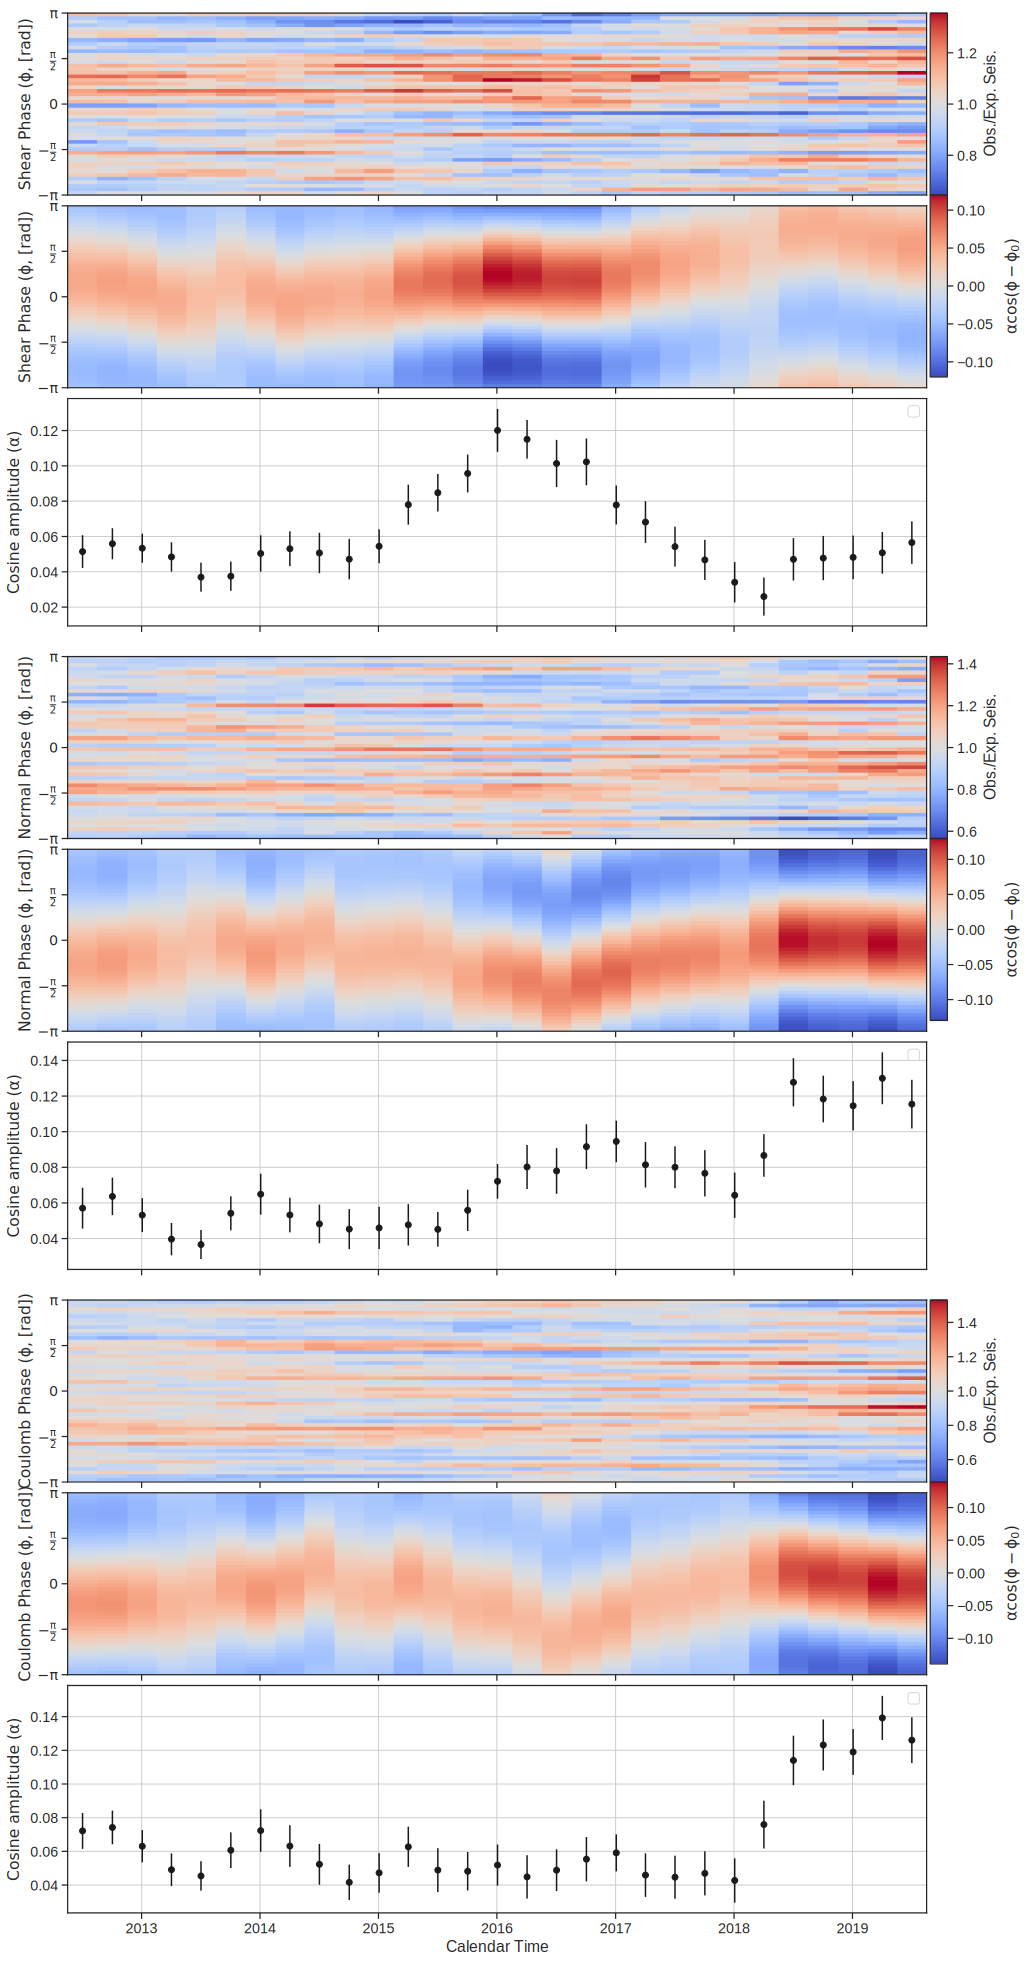

In [211]:
fig, axes = plt.subplots(
    num="instantaneous_phase_all_stress_components", figsize=(15, 30), nrows=len(PHASE_FIELDS)
    )
print(isinstance(axes, np.ndarray))
print(axes[0])
# if ((not isinstance(axes, list)) or (not isinstance(axes, np.ndarray))):
#     axes = [axes]

plt.subplots_adjust(hspace=0.05, right=0.94, top=0.99)

time_periods = list(seismicity_vs_phase_continuous.keys())
time_periods.sort()
time_plot = pd.to_datetime(time_periods)

ytick_loc = [-180.0, -90.0, 0, 90.0, 180.0]
ytick_lab = [r"$-\pi$", r"$-\frac{\pi}{2}$", r"$0$", r"$\frac{\pi}{2}$", r"$\pi$"]

for i, field in enumerate(PHASE_FIELDS):
    stress_name = field.split("_")[-1].capitalize()

    phase_midbins = (
        seismicity_vs_phase_continuous[time_periods[0]][field]["phase_bins"][1:]
        + seismicity_vs_phase_continuous[time_periods[0]][field]["phase_bins"][:-1]
    ) / 2.0

    phase_data = np.zeros(
        (len(time_periods), len(phase_midbins)), dtype=np.float32
    )
    phase_fit = np.zeros(
        (len(time_periods), len(phase_midbins)), dtype=np.float32
    )
    alpha = np.zeros(len(time_periods), dtype=np.float32)
    alpha_err = np.zeros(len(time_periods), dtype=np.float32)
    p_random_walk = np.zeros(len(time_periods), dtype=np.float32)
    for t, tp in enumerate(time_periods):
        alpha[t] = seismicity_vs_phase_continuous[tp][field]["alpha"]
        alpha_err[t] = seismicity_vs_phase_continuous[tp][field]["alpha_err"]
        phase_data[t, :] = seismicity_vs_phase_continuous[tp][field][
            "rate_ratio"
        ]
        phase_fit[t, :] = seistides.cos(
            np.deg2rad(phase_midbins),
            seismicity_vs_phase_continuous[tp][field]["alpha"],
            seismicity_vs_phase_continuous[tp][field]["phi"]
            )
    vmin, vmax = phase_data.min(), phase_data.max()
    absmax = np.abs(phase_data-1.).max()
    vmin, vmax = 1.-absmax, 1.+absmax

    pc = axes[i].pcolormesh(
        time_plot,
        phase_midbins,
        phase_data.T,
        cmap="coolwarm",
        vmin=vmin,
        vmax=vmax,
        rasterized=True,
        label=field.capitalize()
    )

    divider = make_axes_locatable(axes[i])
    cax = divider.append_axes("right", size="2%", pad=0.05)
    plt.colorbar(pc, cax=cax, label="Obs./Exp. Seis.")

    ax_fit = divider.append_axes("bottom", size="100%", pad=0.15)
    ax_fit.sharex(axes[i])
    absmax = np.abs(phase_fit).max()
    vmin, vmax = -absmax, +absmax
    pc_fit = ax_fit.pcolormesh(
        pd.to_datetime(time_periods),
        phase_midbins,
        phase_fit.T,
        cmap="coolwarm",
        vmin=vmin,
        vmax=vmax,
        rasterized=True,
    )


    for ax in [axes[i], ax_fit]:
        ax.set_yticks(ytick_loc)
        ax.set_yticklabels(ytick_lab)
        ax.set_ylabel(f"{stress_name} Phase"r" ($\phi$, [rad])")

    ax_amp = divider.append_axes("bottom", size="125%", pad=0.15)
    ax_amp.sharex(axes[i])
    ax_amp.errorbar(
        time_plot,
        alpha,
        yerr=alpha_err,
        marker="o",
        color="k",
        ls="",
    )
    ax_amp.grid("x")
    ax_amp.set_ylabel(r"Cosine amplitude ($\alpha$)")

    # with open(os.path.join(PATH_PICKLED_INTERPOLATORS, f"ppf_alpha_{stress_name.lower()}.pkl"), mode="rb") as fint:
    #     ppf_alpha = pickle.load(fint)
    # ax_amp.axhline(ppf_alpha(0.98), color="k", ls="-.", zorder=0.5, label="Above line: 98% null hypothesis rejected CI")
    # ax_amp.axhline(ppf_alpha(0.95), color="k", zorder=0.5, label="Above line: 95% null hypothesis rejected CI")
    # ax_amp.axhline(ppf_alpha(0.90), color="k", ls="--", zorder=0.5, label="Above line: 90% null hypothesis rejected CI")
    ax_amp.legend(handlelength=0.9, loc="best")

    plt.draw()
    pos = list(cax.get_position().bounds)
    pos[1] -= pos[3]
    cax2 = fig.add_axes(pos)
    plt.colorbar(pc_fit, cax=cax2, label=r"$\alpha \cos(\phi - \phi_0)$")

    if i < len(PHASE_FIELDS)-1:
        plt.setp(axes[i].get_xticklabels(), visible=False)
        plt.setp(ax_fit.get_xticklabels(), visible=False)
        plt.setp(ax_amp.get_xticklabels(), visible=False)
    else:
        ax_amp.set_xlabel("Calendar Time")


axes[2].set_ylim(-180., +180.)


In [212]:
# fig.savefig(fig._label + ".svg", format="svg", bbox_inches="tight")

## Continuous analysis: Coulomb stress amplitude

In [213]:
fortnightly_phase = FORTNIGHTLY_PHASES[2]
SHORT_WINDOW_DAYS = 3 * 30
OVERLAP = 0.90
N_SHORT_WINDOWS = 128
# N_SHORT_WINDOWS = 64
LARGE_WINDOW_SHIFT = relativedelta(months=3)
large_window_dur = N_SHORT_WINDOWS*(1.-OVERLAP)*SHORT_WINDOW_DAYS + OVERLAP*SHORT_WINDOW_DAYS
print(f"Large window duration: {large_window_dur}")

window_duration = pd.Timedelta(days=large_window_dur)
print(window_duration)

STRESS_FIELDS = ["coulomb_stress"]
DOWNSAMPLE = 2

t_end = pd.Timestamp("2019-07-03")
t_start = t_end - window_duration
seismicity_vs_stress_continuous = {}

while t_start > pd.Timestamp("2009-01-01"):
    print(t_start.strftime("%Y-%m-%d"), "-", t_end.strftime("%Y-%m-%d"))
    seismicity_vs_stress_continuous[t_end.strftime("%Y-%m-%d")] = seistides.composite_rate_ratio_vs_stress(
        cat,
        tidal_stress,
        fortnightly_phase,
        short_window_days=SHORT_WINDOW_DAYS,
        n_short_windows=N_SHORT_WINDOWS,
        overlap=OVERLAP,
        t_end=t_end,
        progress=False,
        stress_bins=STRESS_BINS,
        fields=STRESS_FIELDS,
        downsample=DOWNSAMPLE,
    )
    # fit ratio
    stress_midbins = (
        seismicity_vs_stress_continuous[t_end.strftime("%Y-%m-%d")][
            STRESS_FIELDS[0]
        ]["stress_bins"][1:]
        + seismicity_vs_stress_continuous[t_end.strftime("%Y-%m-%d")][
            STRESS_FIELDS[0]
        ]["stress_bins"][:-1]
    ) / 2.0
    for field in STRESS_FIELDS:
        stress_dict = seismicity_vs_stress_continuous[t_end.strftime("%Y-%m-%d")][field]
        intercept, slope, intercept_err, slope_err = seistides.fit_stress_hist_scipy(
            stress_midbins,
            stress_dict["rate_ratio"],
            stress_dict["rate_ratio_err"],
        )
        stress_dict["intercept"] = intercept
        stress_dict["slope"] = slope
        stress_dict["slope_err"] = slope_err
        Asig_Pa, Asig_Pa_err = seistides.fit_rate_state_bootstrap(
            stress_midbins,
            stress_dict["rate_ratio"],
            stress_dict["rate_ratio_err"],
        )
        Asig_Pa_min = Asig_Pa - Asig_Pa_err
        Asig_Pa_max = Asig_Pa + Asig_Pa_err
        # stress_dict["Asig_kPa"] = Asig_Pa/1.e3
        # stress_dict["Asig_kPa_err"] = Asig_Pa_err/1.e3
        # Asig_Pa, Asig_Pa_min, Asig_Pa_max = fit_rate_state(
        #     stress_midbins,
        #     stress_dict["corrected_pdf"],
        #     stress_dict["corrected_pdf_err"],
        # )
        stress_dict["Asig_kPa"] = Asig_Pa/1.e3
        stress_dict["Asig_kPa_min"] = Asig_Pa_min/1.e3
        stress_dict["Asig_kPa_max"] = Asig_Pa_max/1.e3
    t_start -= LARGE_WINDOW_SHIFT
    t_end -= LARGE_WINDOW_SHIFT

Large window duration: 1232.9999999999998
1232 days 23:59:59.999999968
2016-02-16 - 2019-07-03
2015-11-16 - 2019-04-03
2015-08-16 - 2019-01-03
2015-05-16 - 2018-10-03
2015-02-16 - 2018-07-03
2014-11-16 - 2018-04-03
2014-08-16 - 2018-01-03
2014-05-16 - 2017-10-03
2014-02-16 - 2017-07-03
2013-11-16 - 2017-04-03
2013-08-16 - 2017-01-03
2013-05-16 - 2016-10-03
2013-02-16 - 2016-07-03
2012-11-16 - 2016-04-03
2012-08-16 - 2016-01-03
2012-05-16 - 2015-10-03
2012-02-16 - 2015-07-03
2011-11-16 - 2015-04-03
2011-08-16 - 2015-01-03
2011-05-16 - 2014-10-03
2011-02-16 - 2014-07-03
2010-11-16 - 2014-04-03
2010-08-16 - 2014-01-03
2010-05-16 - 2013-10-03
2010-02-16 - 2013-07-03
2009-11-16 - 2013-04-03
2009-08-16 - 2013-01-03
2009-05-16 - 2012-10-03
2009-02-16 - 2012-07-03


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


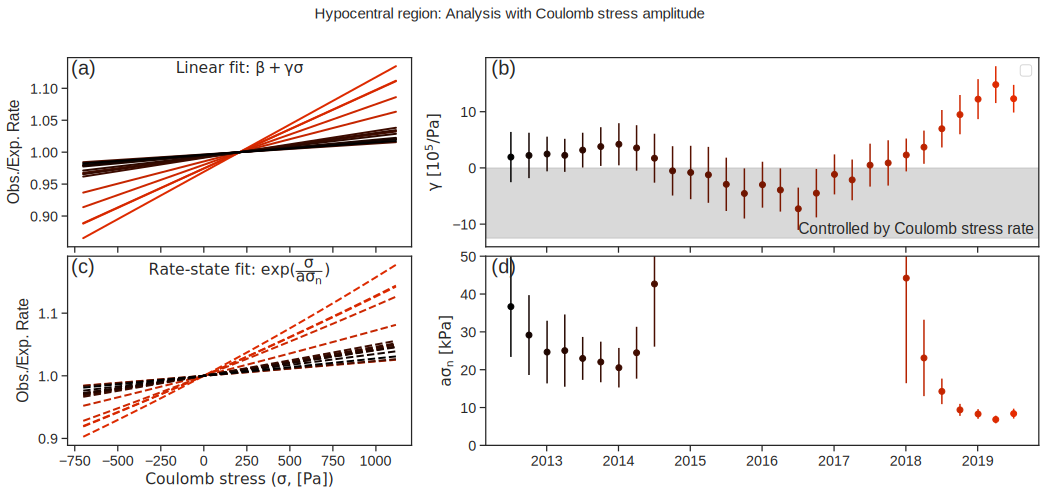

In [214]:
fig = plt.figure("stress_amplitude", figsize=(15, 7))
gs = fig.add_gridspec(nrows=2, ncols=5)

fig.suptitle(
    f"Hypocentral region: Analysis with Coulomb stress amplitude",#\n(median across {N_SHORT_WINDOWS} windows, float32, incorrect shear sign)",
    fontsize=15
    )


slope_scaling = 1.e5

plt.subplots_adjust(hspace=0.05, right=0.99, top=0.88, left=0.09, wspace=0.55)

time_periods = list(seismicity_vs_stress_continuous.keys())
time_periods.sort()
time_plot = pd.to_datetime(time_periods)

# color map for time stress
cnorm = Normalize(
    vmin=pd.Timestamp(time_periods[0]).timestamp(),
    vmax=pd.Timestamp(time_periods[-1]).timestamp(),
)
scalar_map = ScalarMappable(cmap=cc.cm.kr, norm=cnorm)

field = "coulomb_stress"

stress_midbins = (
    seismicity_vs_stress_continuous[time_periods[0]][field]["stress_bins"][1:]
    + seismicity_vs_stress_continuous[time_periods[0]][field]["stress_bins"][:-1]
) / 2.0

# phase_data = np.zeros(
#     (len(time_periods), len(phase_midbins)), dtype=np.float32
# )
linear_fit = np.zeros((len(time_periods), len(stress_midbins)), dtype=np.float32)
rate_state_fit = np.ones((len(time_periods), len(stress_midbins)), dtype=np.float32)
slope = np.zeros(len(time_periods), dtype=np.float32)
slope_err = np.zeros(len(time_periods), dtype=np.float32)
Asig_kPa = np.zeros(len(time_periods), dtype=np.float32)
# Asig_kPa_err = np.zeros(len(time_periods), dtype=np.float32)
Asig_kPa_min = np.zeros(len(time_periods), dtype=np.float32)
Asig_kPa_max = np.zeros(len(time_periods), dtype=np.float32)
for t, tp in enumerate(time_periods):
    slope[t] = seismicity_vs_stress_continuous[tp][field]["slope"]
    slope_err[t] = seismicity_vs_stress_continuous[tp][field]["slope_err"]
    Asig_kPa[t] = seismicity_vs_stress_continuous[tp][field]["Asig_kPa"]
    # Asig_kPa_err[t] = seismicity_vs_stress_continuous[tp][field]["Asig_kPa_err"]
    Asig_kPa_min[t] = seismicity_vs_stress_continuous[tp][field]["Asig_kPa_min"]
    Asig_kPa_max[t] = seismicity_vs_stress_continuous[tp][field]["Asig_kPa_max"]
    linear_fit[t, :] = (
        seismicity_vs_stress_continuous[tp][field]["intercept"]
        + slope[t]*stress_midbins
    )
    if Asig_kPa[t] < 150.:
        rate_state_fit[t, :] = (
            seistides.rate_state(stress_midbins, Asig_kPa[t]*1000.)
        )

ax1 = fig.add_subplot(gs[0, :2])
ax2 = fig.add_subplot(gs[0, 2:])
ax3 = fig.add_subplot(gs[1, :2])
ax4 = fig.add_subplot(gs[1, 2:], sharex=ax2)

inc = 0.0
# plot_times = ["2013-07-03", "2015-07-03", "2017-07-03", "2019-07-03"]
plot_times = time_periods
for tp in plot_times:
    t = time_periods.index(tp)
    time = pd.Timestamp(tp)
    color = scalar_map.to_rgba(time.timestamp())
    zorder = len(plot_times)-t
    # if Asig_kPa[t] < 150.:
    if slope[t] > 1*1.e-5:
        ax1.plot(
            stress_midbins,
            inc + linear_fit[t, :],
            color=color,
            lw=2,
            label=time.strftime("%Y-%m-%d"),
            zorder=zorder,
        )
        ax3.plot(
            stress_midbins,
            rate_state_fit[t, :],
            color=color,
            lw=2,
            ls="--",
            label=time.strftime("%Y-%m-%d"),
            zorder=zorder,
        )
        # ax2.errorbar(
        #     time,
        #     slope_scaling*slope[t],
        #     yerr=slope_scaling*slope_err[t],
        #     color=color,
        #     marker="o",
        #     markersize=10,
        # )
        # err = np.array([[Asig_kPa[t]-Asig_kPa_min[t]], [Asig_kPa_max[t]-Asig_kPa[t]]])
        # ax4.errorbar(
        #     time, Asig_kPa[t], yerr=err, color=color, marker="o", markersize=10
        #     )

for tp in time_periods:
    t = time_periods.index(tp)
    time = pd.Timestamp(tp)
    color = scalar_map.to_rgba(time.timestamp())
    ax2.errorbar(
        time, slope_scaling*slope[t], yerr=slope_scaling*slope_err[t], color=color, marker="o"
    )
    # if Asig_kPa[t] < 150.:
    if slope[t] > 1*1.e-5:
        # ax4.errorbar(
        #     time, Asig_kPa[t], yerr=Asig_kPa_err[t], color=color, marker="o"
        #     )
        err = np.array([[Asig_kPa[t]-Asig_kPa_min[t]], [Asig_kPa_max[t]-Asig_kPa[t]]])
        ax4.errorbar(
            time, Asig_kPa[t], yerr=err, color=color, marker="o"
            )

xlims = ax2.get_xlim()
ax2.fill_between(
    xlims,
    0.,
    y2=ax2.get_ylim()[0],
    color="dimgrey",
    alpha=0.25,
    zorder=-1.
)
ax2.set_xlim(xlims)
ax2.text(0.99, 0.05, "Controlled by Coulomb stress rate", ha="right", va="bottom", transform=ax2.transAxes)
ax4.set_ylim(0., 50.)

ax3.set_xlabel(r"Coulomb stress ($\sigma$, [Pa])")
ax2.set_ylabel(r"$\gamma$ [$10^5$/Pa]")
ax4.set_ylabel(r"$a \sigma_n$ [kPa]")

ax1.set_title(r"Linear fit: $\beta + \gamma \sigma$", y=0.95, va="top")
ax3.set_title(r"Rate-state fit: $\exp(\dfrac{\sigma}{a \sigma_n})$", y=0.95, va="top")

# # shade 95% CI
# with open(os.path.join(PATH_PICKLED_INTERPOLATORS, "ppf_slope_coulomb.pkl"), mode="rb") as fint:
#     ppf_slope = pickle.load(fint)
# ax2.axhline(slope_scaling*ppf_slope(0.98), color="k", ls="-.", zorder=0.5, label="Above line: 98% null hypothesis rejected CI")
# ax2.axhline(slope_scaling*ppf_slope(0.95), color="k", zorder=0.5, label="Above line: 95% null hypothesis rejected CI")
# ax2.axhline(slope_scaling*ppf_slope(0.90), color="k", ls="--", zorder=0.5, label="Above line: 90% null hypothesis rejected CI")
ax2.legend(handlelength=0.9, loc="best")

for ax in [ax1, ax2]:
    plt.setp(ax.get_xticklabels(), visible=False)
for ax in [ax1, ax3]:
    ax.set_ylabel("Obs./Exp. Rate")

# ax1.legend(loc="lower right", handlelength=0.5)

for i, ax in enumerate([ax1, ax2, ax3, ax4]):
    ax.text(
        0.01,
        0.99,
        f"({string.ascii_lowercase[i]})",
        va="top",
        fontsize=20,
        ha="left",
        # bbox={"facecolor": "white", "alpha": 0.75},
        transform=ax.transAxes,
    )


In [215]:
# fig.savefig(fig._label + ".svg", format="svg", bbox_inches="tight")

## Continuous analysis: Instantaneous volumetric phase

In [216]:
SHORT_WINDOW_DAYS = 3 * 30
OVERLAP = 0.90
N_SHORT_WINDOWS = 128
large_window_dur = N_SHORT_WINDOWS*(1.-OVERLAP)*SHORT_WINDOW_DAYS + OVERLAP*SHORT_WINDOW_DAYS
print(f"Large window duration: {large_window_dur}")
LARGE_WINDOW_SHIFT = relativedelta(months=3)

window_duration = pd.Timedelta(days=large_window_dur)
print(window_duration)

PHASE_FIELDS = ["instantaneous_phase_volumetric"]

DOWNSAMPLE = 2

t_end = pd.Timestamp("2019-07-03")
t_start = t_end - window_duration
seismicity_vs_phase_continuous = {}
median_depth = {}

while t_end-window_duration > pd.Timestamp("2009-01-01"):
    print(t_start.strftime("%Y-%m-%d"), "-", t_end.strftime("%Y-%m-%d"))
    seismicity_vs_phase_continuous[
        t_end.strftime("%Y-%m-%d")
    ] = seistides.composite_rate_ratio_vs_phase(
        cat,
        tidal_stress,
        short_window_days=SHORT_WINDOW_DAYS,
        n_short_windows=N_SHORT_WINDOWS,
        overlap=OVERLAP,
        t_end=t_end,
        progress=False,        
        phase_bins=PHASE_BINS,
        fields=PHASE_FIELDS,
        downsample=DOWNSAMPLE,
    )
    subcat = cat[(cat["origin_time"] > t_start) & (cat["origin_time"] < t_end)]
    median_depth[t_end.strftime("%Y-%m-%d")] = np.median(subcat["depth"])
    # fit ratio
    phase_midbins = (
        seismicity_vs_phase_continuous[t_end.strftime("%Y-%m-%d")][PHASE_FIELDS[0]][
            "phase_bins"
        ][1:]
        + seismicity_vs_phase_continuous[t_end.strftime("%Y-%m-%d")][
            PHASE_FIELDS[0]
        ]["phase_bins"][:-1]
    ) / 2.0
    for field in PHASE_FIELDS:
        alpha, phi, alpha_err, phi_err = seistides.fit_semidiurnal_triggering_bootstrap(
            phase_midbins,
            seismicity_vs_phase_continuous[t_end.strftime("%Y-%m-%d")][field][
                "rate_ratio"
            ],
            seismicity_vs_phase_continuous[t_end.strftime("%Y-%m-%d")][field][
                "rate_ratio_err"
            ],
            n_bootstrap=100,
            objective="negative-log-likelihood"
        )
        seismicity_vs_phase_continuous[t_end.strftime("%Y-%m-%d")][field][
            "alpha"
        ] = alpha
        seismicity_vs_phase_continuous[t_end.strftime("%Y-%m-%d")][field][
            "phi"
        ] = phi
        seismicity_vs_phase_continuous[t_end.strftime("%Y-%m-%d")][field][
            "alpha_err"
        ] = alpha_err
        seismicity_vs_phase_continuous[t_end.strftime("%Y-%m-%d")][field][
            "phi_err"
        ] = phi_err
    t_start -= LARGE_WINDOW_SHIFT
    t_end -= LARGE_WINDOW_SHIFT


Large window duration: 1232.9999999999998
1232 days 23:59:59.999999968
2016-02-16 - 2019-07-03
2015-11-16 - 2019-04-03
2015-08-16 - 2019-01-03
2015-05-16 - 2018-10-03
2015-02-16 - 2018-07-03
2014-11-16 - 2018-04-03
2014-08-16 - 2018-01-03
2014-05-16 - 2017-10-03
2014-02-16 - 2017-07-03
2013-11-16 - 2017-04-03
2013-08-16 - 2017-01-03
2013-05-16 - 2016-10-03
2013-02-16 - 2016-07-03
2012-11-16 - 2016-04-03
2012-08-16 - 2016-01-03
2012-05-16 - 2015-10-03
2012-02-16 - 2015-07-03
2011-11-16 - 2015-04-03
2011-08-16 - 2015-01-03
2011-05-16 - 2014-10-03
2011-02-16 - 2014-07-03
2010-11-16 - 2014-04-03
2010-08-16 - 2014-01-03
2010-05-16 - 2013-10-03
2010-02-16 - 2013-07-03
2009-11-16 - 2013-04-03
2009-08-16 - 2013-01-03
2009-05-16 - 2012-10-03
2009-02-16 - 2012-07-03


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


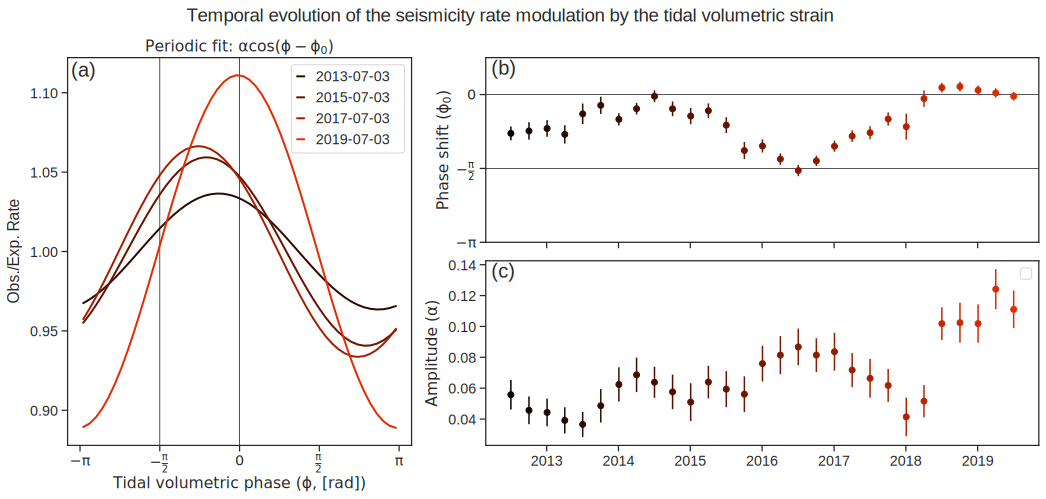

In [217]:
fig = plt.figure("instantaneous_phase_volumetric_strain", figsize=(15, 7))
gs = fig.add_gridspec(nrows=2, ncols=5)

fig.suptitle("Temporal evolution of the seismicity rate modulation by the tidal volumetric strain")

plt.subplots_adjust(hspace=0.10, right=0.99, top=0.88, left=0.09, wspace=0.55)

time_periods = list(seismicity_vs_phase_continuous.keys())
time_periods.sort()
time_plot = pd.to_datetime(time_periods)

# color map for time stress
cnorm = Normalize(
    vmin=pd.Timestamp(time_periods[0]).timestamp(),
    vmax=pd.Timestamp(time_periods[-1]).timestamp(),
)
scalar_map = ScalarMappable(cmap=cc.cm.kr, norm=cnorm)

tick_loc = [-180.0, -90.0, 0, 90.0, 180.0]
tick_lab = [r"$-\pi$", r"$-\frac{\pi}{2}$", r"$0$", r"$\frac{\pi}{2}$", r"$\pi$"]

field = "instantaneous_phase_volumetric"

phase_midbins = (
    seismicity_vs_phase_continuous[time_periods[0]][field]["phase_bins"][1:]
    + seismicity_vs_phase_continuous[time_periods[0]][field]["phase_bins"][:-1]
) / 2.0

phase_fit = np.zeros((len(time_periods), len(phase_midbins)), dtype=np.float32)
alpha = np.zeros(len(time_periods), dtype=np.float32)
alpha_err = np.zeros(len(time_periods), dtype=np.float32)
phi = np.zeros(len(time_periods), dtype=np.float32)
phi_err = np.zeros(len(time_periods), dtype=np.float32)
for t, tp in enumerate(time_periods):
    alpha[t] = seismicity_vs_phase_continuous[tp][field]["alpha"]
    alpha_err[t] = seismicity_vs_phase_continuous[tp][field]["alpha_err"]
    phi[t] = seismicity_vs_phase_continuous[tp][field]["phi"]
    phi_err[t] = seismicity_vs_phase_continuous[tp][field]["phi_err"]
    phase_fit[t, :] = seistides.cos(
        np.deg2rad(phase_midbins),
        seismicity_vs_phase_continuous[tp][field]["alpha"],
        seismicity_vs_phase_continuous[tp][field]["phi"],
    )

ax1 = fig.add_subplot(gs[:, :2])
ax2 = fig.add_subplot(gs[0, 2:])
ax3 = fig.add_subplot(gs[1, 2:], sharex=ax2)

inc = 1.0
plot_times = ["2013-07-03", "2015-07-03", "2017-07-03", "2019-07-03"]
for tp in plot_times:
    t = time_periods.index(tp)
    time = pd.Timestamp(tp)
    color = scalar_map.to_rgba(time.timestamp())
    ax1.plot(
        phase_midbins,
        inc + phase_fit[t, :],
        color=color,
        lw=2,
        label=time.strftime("%Y-%m-%d"),
    )

for tp in time_periods:
    t = time_periods.index(tp)
    time = pd.Timestamp(tp)
    color = scalar_map.to_rgba(time.timestamp())
    ax2.errorbar(
        time, np.rad2deg(phi[t]), yerr=np.rad2deg(phi_err[t]), color=color, marker="o"
    )
    ax3.errorbar(time, alpha[t], yerr=alpha_err[t], color=color, marker="o")
ax2.axhline(0.0, lw=0.75, color="k", zorder=-1.0)
ax2.axhline(-90.0, lw=0.75, color="k", zorder=-1.0)
ax1.axvline(0.0, lw=0.75, color="k", zorder=-1.0)
ax1.axvline(-90.0, lw=0.75, color="k", zorder=-1.0)

ax1.set_xticks(tick_loc)
ax1.set_xticklabels(tick_lab)

ax1.set_ylabel("Obs./Exp. Rate")

ax2.set_yticks(tick_loc[:3])
ax2.set_yticklabels(tick_lab[:3])

ax1.set_title(r"Periodic fit: $\alpha \cos(\phi - \phi_0)$")
ax1.set_xlabel(r"Tidal volumetric phase ($\phi$, [rad])")

ax2.set_ylabel(r"Phase shift ($\phi_0$)")

ax3.set_ylabel(r"Amplitude ($\alpha$)")

plt.setp(ax2.get_xticklabels(), visible=False)

ax1.legend(loc="upper right", handlelength=0.5)

ax2.set_ylim(-180., 45.)
# shade 95% CI
# with open(os.path.join(PATH_PICKLED_INTERPOLATORS, "ppf_alpha_volumetric.pkl"), mode="rb") as fint:
#     ppf_alpha = pickle.load(fint)
# ax3.axhline(ppf_alpha(0.98), color="k", ls="-.", zorder=0.5, label="Above line: 98% null hypothesis rejected CI") 
# ax3.axhline(ppf_alpha(0.95), color="k", zorder=0.5, label="Above line: 95% null hypothesis rejected CI")
# ax3.axhline(ppf_alpha(0.90), color="k", ls="--", zorder=0.5, label="Above line: 90% null hypothesis rejected CI")
ax3.legend(handlelength=0.9, loc="best")

for i, ax in enumerate([ax1, ax2, ax3]):
    ax.text(
        0.01,
        0.99,
        f"({string.ascii_lowercase[i]})",
        va="top",
        fontsize=20,
        ha="left",
        # bbox={"facecolor": "white", "alpha": 0.75},
        transform=ax.transAxes,
    )


In [218]:
# fig.savefig(fig._label + ".svg", format="svg", bbox_inches="tight")

## Continuous analysis: Volumetric strain

In [219]:
SHORT_WINDOW_DAYS = 3 * 30
OVERLAP = 0.90
N_SHORT_WINDOWS = 128
LARGE_WINDOW_SHIFT = relativedelta(months=3)
large_window_dur = N_SHORT_WINDOWS*(1.-OVERLAP)*SHORT_WINDOW_DAYS + OVERLAP*SHORT_WINDOW_DAYS
print(f"Large window duration: {large_window_dur}")

window_duration = pd.Timedelta(days=large_window_dur)
print(window_duration)

STRESS_FIELDS = ["volumetric_strain"]
DOWNSAMPLE = 2

t_end = pd.Timestamp("2019-07-03")
t_start = t_end - window_duration
seismicity_vs_stress_continuous = {}

while t_start > pd.Timestamp("2009-01-01"):
    print(t_start.strftime("%Y-%m-%d"), "-", t_end.strftime("%Y-%m-%d"))
    seismicity_vs_stress_continuous[t_end.strftime("%Y-%m-%d")] = seistides.composite_rate_ratio_vs_stress(
        cat,
        tidal_stress,
        short_window_days=SHORT_WINDOW_DAYS,
        n_short_windows=N_SHORT_WINDOWS,
        overlap=OVERLAP,
        t_end=t_end,
        progress=False,
        stress_bins=STRESS_BINS,
        fields=STRESS_FIELDS,
        downsample=DOWNSAMPLE,
    )
    # fit ratio
    stress_midbins = (
        seismicity_vs_stress_continuous[t_end.strftime("%Y-%m-%d")][
            STRESS_FIELDS[0]
        ]["stress_bins"][1:]
        + seismicity_vs_stress_continuous[t_end.strftime("%Y-%m-%d")][
            STRESS_FIELDS[0]
        ]["stress_bins"][:-1]
    ) / 2.0
    for field in STRESS_FIELDS:
        stress_dict = seismicity_vs_stress_continuous[t_end.strftime("%Y-%m-%d")][field]
        intercept, slope, intercept_err, slope_err = seistides.fit_stress_hist_scipy(
            stress_midbins,
            stress_dict["rate_ratio"],
            stress_dict["rate_ratio_err"],
        )
        stress_dict["intercept"] = intercept
        stress_dict["slope"] = slope
        stress_dict["slope_err"] = slope_err
        # Asig_Pa, Asig_Pa_err = fit_rate_state_bootstrap(
        #     stress_midbins,
        #     stress_dict["corrected_pdf"],
        #     stress_dict["corrected_pdf_err"],
        # )
        # stress_dict["Asig_kPa"] = Asig_Pa/1.e3
        # stress_dict["Asig_kPa_err"] = Asig_Pa_err/1.e3
        Asig_Pa, Asig_Pa_min, Asig_Pa_max = seistides.fit_rate_state(
            stress_midbins,
            stress_dict["rate_ratio"],
            stress_dict["rate_ratio_err"],
        )
        stress_dict["Asig_kPa"] = Asig_Pa/1.e3
        stress_dict["Asig_kPa_min"] = Asig_Pa_min/1.e3
        stress_dict["Asig_kPa_max"] = Asig_Pa_max/1.e3
    t_start -= LARGE_WINDOW_SHIFT
    t_end -= LARGE_WINDOW_SHIFT

Large window duration: 1232.9999999999998
1232 days 23:59:59.999999968
2016-02-16 - 2019-07-03
2015-11-16 - 2019-04-03
2015-08-16 - 2019-01-03
2015-05-16 - 2018-10-03
2015-02-16 - 2018-07-03
2014-11-16 - 2018-04-03
2014-08-16 - 2018-01-03
2014-05-16 - 2017-10-03
2014-02-16 - 2017-07-03
2013-11-16 - 2017-04-03
2013-08-16 - 2017-01-03
2013-05-16 - 2016-10-03
2013-02-16 - 2016-07-03
2012-11-16 - 2016-04-03
2012-08-16 - 2016-01-03
2012-05-16 - 2015-10-03
2012-02-16 - 2015-07-03
2011-11-16 - 2015-04-03
2011-08-16 - 2015-01-03
2011-05-16 - 2014-10-03
2011-02-16 - 2014-07-03
2010-11-16 - 2014-04-03
2010-08-16 - 2014-01-03
2010-05-16 - 2013-10-03
2010-02-16 - 2013-07-03
2009-11-16 - 2013-04-03
2009-08-16 - 2013-01-03
2009-05-16 - 2012-10-03
2009-02-16 - 2012-07-03


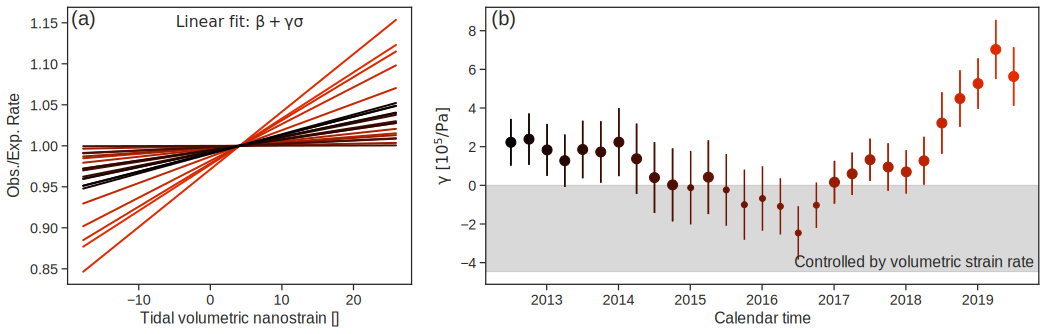

In [220]:
fig = plt.figure("volumetric_strain_amplitude", figsize=(15, 5))
gs = fig.add_gridspec(nrows=1, ncols=5)

# fig.suptitle("Temporal evolution of the sensitivity to tidal coulomb stress")

plt.subplots_adjust(hspace=0.05, right=0.99, top=0.88, left=0.09, wspace=0.55)

time_periods = list(seismicity_vs_phase_continuous.keys())
time_periods.sort()
time_plot = pd.to_datetime(time_periods)

# color map for time stress
cnorm = Normalize(
    vmin=pd.Timestamp(time_periods[0]).timestamp(),
    vmax=pd.Timestamp(time_periods[-1]).timestamp(),
)
scalar_map = ScalarMappable(cmap=cc.cm.kr, norm=cnorm)

field = "volumetric_strain"

stress_midbins = (
    seismicity_vs_stress_continuous[time_periods[0]][field]["stress_bins"][1:]
    + seismicity_vs_stress_continuous[time_periods[0]][field]["stress_bins"][:-1]
) / 2.0

linear_fit = np.zeros((len(time_periods), len(stress_midbins)), dtype=np.float32)
slope = np.zeros(len(time_periods), dtype=np.float32)
slope_err = np.zeros(len(time_periods), dtype=np.float32)
for t, tp in enumerate(time_periods):
    slope[t] = seismicity_vs_stress_continuous[tp][field]["slope"]
    slope_err[t] = seismicity_vs_stress_continuous[tp][field]["slope_err"]
    linear_fit[t, :] = (
        seismicity_vs_stress_continuous[tp][field]["intercept"]
        + slope[t]*stress_midbins
    )


ax1 = fig.add_subplot(gs[:2])
ax2 = fig.add_subplot(gs[2:])

inc = 0.0
plot_times = time_periods
for tp in plot_times:
    t = time_periods.index(tp)
    time = pd.Timestamp(tp)
    color = scalar_map.to_rgba(time.timestamp())
    zorder = len(plot_times)-t
    if slope[t] > 0:
        ax1.plot(
            stress_midbins,
            inc + linear_fit[t, :],
            color=color,
            lw=2,
            label=time.strftime("%Y-%m-%d"),
            zorder=zorder,
        )

        ax2.errorbar(
            time,
            1000.*slope[t],
            yerr=1000.*slope_err[t],
            color=color,
            marker="o",
            markersize=10,
        )


for tp in time_periods:
    t = time_periods.index(tp)
    time = pd.Timestamp(tp)
    color = scalar_map.to_rgba(time.timestamp())
    ax2.errorbar(
        time, 1000.*slope[t], yerr=1000.*slope_err[t], color=color, marker="o"
    )


xlims = ax2.get_xlim()
ax2.fill_between(
    xlims,
    0.,
    y2=ax2.get_ylim()[0],
    color="dimgrey",
    alpha=0.25,
    zorder=-1.
)
ax2.set_xlim(xlims)
ax2.text(0.99, 0.05, "Controlled by volumetric strain rate", ha="right", va="bottom", transform=ax2.transAxes)

ax2.set_ylabel(r"$\gamma$ [$10^5$/Pa]")
ax2.set_xlabel("Calendar time")

ax1.set_title(r"Linear fit: $\beta + \gamma \sigma$", y=0.95, va="top")
ax1.set_xlabel("Tidal volumetric nanostrain []")

# for ax in [ax1, ax2]:
#     plt.setp(ax.get_xticklabels(), visible=False)
for ax in [ax1]:
    ax.set_ylabel("Obs./Exp. Rate")

# ax1.legend(loc="lower right", handlelength=0.5)

for i, ax in enumerate([ax1, ax2]):
    ax.text(
        0.01,
        0.99,
        f"({string.ascii_lowercase[i]})",
        va="top",
        fontsize=20,
        ha="left",
        # bbox={"facecolor": "white", "alpha": 0.75},
        transform=ax.transAxes,
    )


In [221]:
# fig.savefig(fig._label + ".svg", format="svg", bbox_inches="tight")

## Selected analysis: Instantaneous Coulomb Phase

In [222]:
# ======================================================
#          bin on semi-diurnal phase
# ======================================================
SHORT_WINDOW_DAYS = 3*30
OVERLAP = 0.90
N_SHORT_WINDOWS = 128
large_window_dur = N_SHORT_WINDOWS*(1.-OVERLAP)*SHORT_WINDOW_DAYS + OVERLAP*SHORT_WINDOW_DAYS
print(f"Large window duration: {large_window_dur}")
LARGE_WINDOW_SHIFT = relativedelta(years=2)


# check parameters
print("Length of short window: ", SHORT_WINDOW_DAYS)
print("Number of averaging short windows: ", N_SHORT_WINDOWS)
print(f"Overlap between short windows: {OVERLAP:.2f}")


PHASE_FIELDS = ["instantaneous_phase_coulomb", "instantaneous_phase_normal"]

DOWNSAMPLE = 2

window_duration = pd.Timedelta(days=large_window_dur)
t_end = pd.Timestamp("2019-07-03")
t_start = t_end - window_duration

seismicity_vs_phase = {}
while t_start > pd.Timestamp("2009-01-01"):
    print(t_start.strftime("%Y-%m-%d"), "-", t_end.strftime("%Y-%m-%d"))
    seismicity_vs_phase[t_end.strftime("%Y-%m-%d")] = seistides.composite_rate_ratio_vs_phase(
        cat,
        tidal_stress,
        short_window_days=SHORT_WINDOW_DAYS,
        n_short_windows=N_SHORT_WINDOWS,
        overlap=OVERLAP,
        t_end=t_end,
        progress=True,
        phase_bins=PHASE_BINS,
        fields=PHASE_FIELDS,
        downsample=DOWNSAMPLE,
    )
    seismicity_vs_phase[t_end.strftime("%Y-%m-%d")]["num_events"] = (
        len(cat[(cat["origin_time"] < t_end) & (cat["origin_time"] >= t_start)])
    )
    t_start -= LARGE_WINDOW_SHIFT
    t_end -= LARGE_WINDOW_SHIFT


Large window duration: 1232.9999999999998
Length of short window:  90
Number of averaging short windows:  128
Overlap between short windows: 0.90
2016-02-16 - 2019-07-03


Computing in sub-windows: 100%|██████████| 128/128 [00:00<00:00, 161.57it/s]


2014-02-16 - 2017-07-03


Computing in sub-windows: 100%|██████████| 128/128 [00:00<00:00, 167.21it/s]


2012-02-16 - 2015-07-03


Computing in sub-windows: 100%|██████████| 128/128 [00:00<00:00, 163.48it/s]


2010-02-16 - 2013-07-03


Computing in sub-windows: 100%|██████████| 128/128 [00:00<00:00, 164.48it/s]


0.037597276 0.009739533
0.043402124 0.01185475
0.078397706 0.011878142
0.11976895 0.014731271
seismicity_and_tidal_phase_entire


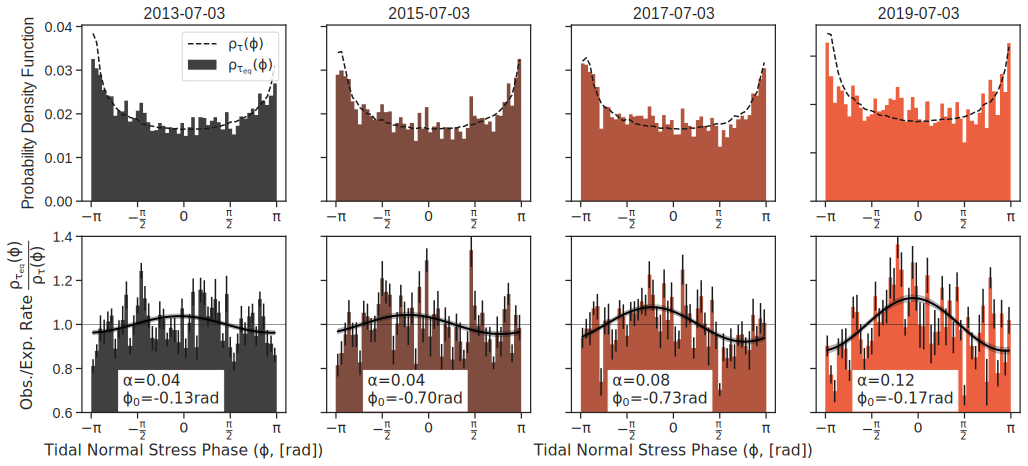

In [223]:
ratio = "rate_ratio"
stress_type = "normal"
phase = f"instantaneous_phase_{stress_type}"

fig, axes = plt.subplots(
    num=f"seismicity_and_tidal_phase",
    ncols=len(seismicity_vs_phase),
    nrows=2,
    figsize=(15, 7),
)
plt.subplots_adjust(right=0.95, left=0.08)
# fig.suptitle(
#     "Seismicity rate vs. tidal Coulomb stress phase",
#     fontsize=20,
# )

time_periods = list(seismicity_vs_phase.keys())
time_periods.sort()
if "all" in time_periods:
    time_periods.remove("all")

bin_width = (
    seismicity_vs_phase[time_periods[0]][phase]["phase_bins"][1]
    - seismicity_vs_phase[time_periods[0]][phase]["phase_bins"][0]
)
barplot_params = {"edgecolor": "none", "align": "edge", "width": bin_width, "rasterized": True, "alpha": 0.75}


# color map for time scale
cnorm = Normalize(
    vmin=pd.Timestamp(time_periods[0]).timestamp(),
    vmax=pd.Timestamp(time_periods[-1]).timestamp(),
)
scalar_map = ScalarMappable(cmap=cc.cm.kr, norm=cnorm)

vmax, vmin = -10., +10.
for i, key in enumerate(time_periods):
    mid_bins = (
        seismicity_vs_phase[key][phase]["phase_bins"][:-1]
        + bin_width / 2.0
    )
    color = scalar_map.to_rgba(pd.Timestamp(key).timestamp())
    axes[0, i].set_title(key)
    bin_width = (
        seismicity_vs_phase[key][phase]["phase_bins"][1]
        - seismicity_vs_phase[key][phase]["phase_bins"][0]
    )
    axes[0, i].bar(
        seismicity_vs_phase[key][phase]["phase_bins"][:-1],
        seismicity_vs_phase[key][phase]["observed_rate"],
        color=color,
        label=r"$\rho_{\tau_{eq}}(\phi)$",
        **barplot_params,
    )
    axes[0, i].plot(
        mid_bins,
        seismicity_vs_phase[key][phase]["expected_rate"],
        color="k",
        ls="--",
        label=r"$\rho_{\tau}(\phi)$",
    )
    axes[1, i].bar(
        seismicity_vs_phase[key][phase]["phase_bins"][:-1],
        seismicity_vs_phase[key][phase][ratio],
        yerr=seismicity_vs_phase[key][phase][f"{ratio}_err"],
        color=color,
        **barplot_params,
    )
    if seismicity_vs_phase[key][phase][ratio].min() < vmin:
        vmin = seismicity_vs_phase[key][phase][ratio].min()
    if seismicity_vs_phase[key][phase][ratio].max() > vmax:
        vmax = seismicity_vs_phase[key][phase][ratio].max()
    # fit ratio
    a, b, a_err, b_err = seistides.fit_semidiurnal_triggering_bootstrap(
        mid_bins,
        seismicity_vs_phase[key][phase][ratio],
        seismicity_vs_phase[key][phase][f"{ratio}_err"],
        n_bootstrap=100,
        objective="negative-log-likelihood"
        # objective="l2"
    )
    seismicity_vs_phase[key][phase]["alpha"] = a
    seismicity_vs_phase[key][phase]["phi"] = b
    print(a, a_err)

    fit = 1.0 + seistides.cos(np.deg2rad(mid_bins), a, b)
    fit_err = seistides.fit_errors(np.deg2rad(mid_bins), a, b, a_err, b_err)
    axes[1, i].plot(mid_bins, fit, lw=2, color="black")
    axes[1, i].fill_between(
        mid_bins,
        fit - fit_err,
        fit + fit_err,
        color="k",
        alpha=0.25,
    )

    axes[1, i].text(
        0.20,
        0.05,
        r"$\alpha$=" f"{a:.2f}\n" r"$\phi_0$=" f"{b:.2f}rad",
        bbox={"facecolor": "white"},
        transform=axes[1, i].transAxes,
    )
    if i == 0:
        axes[0, i].legend(loc="upper right")

axes[0, 0].set_ylabel("Probability Density Function")
axes[1, 0].set_ylabel(r"Obs./Exp. Rate $\dfrac{\rho_{\tau_{eq}}(\phi)}{\rho_{\tau}(\phi)}$")
# axes[1, 0].set_ylabel(r"Obs./Exp. Rate $\rho_{\tau_{eq}}(\phi)/\rho_{\tau}(\phi)$")
for ax in axes[1, ::2]:
    ax.set_xlabel(f"Tidal {stress_type.capitalize()} Stress Phase "r"($\phi$, [rad])")

xtick_loc = [-180.0, -90.0, 0, 90.0, 180.0]
xtick_lab = [r"$-\pi$", r"$-\frac{\pi}{2}$", r"$0$", r"$\frac{\pi}{2}$", r"$\pi$"]
for i in range(1, axes.shape[1]):
    if i != axes.shape[1] - 1:
        axes[0, i].sharey(axes[0, 0])
    axes[1, i].sharey(axes[1, 0])
    plt.setp(axes[0, i].get_yticklabels(), visible=False)
    plt.setp(axes[1, i].get_yticklabels(), visible=False)
for ax in axes.flatten():
    ax.set_xticks(xtick_loc)
    ax.set_xticklabels(xtick_lab)
for ax in axes[1, :]:
    ax.set_ylim(int(10.*vmin)/10., int(10.*vmax+1)/10.)
    ax.axhline(1., color="k", lw=0.50)

fig.set_facecolor("w")
fig._label += f"_{fortnightly_phase.split()[0]}"
print(fig._label)


## Selected analysis: Coulomb Stress Amplitude

In [224]:
# ======================================================
#         bin on tidal stress values
# ======================================================
SHORT_WINDOW_DAYS = 3*30
OVERLAP = 0.90
N_SHORT_WINDOWS = 128
LARGE_WINDOW_SHIFT = relativedelta(years=2)
DOWNSAMPLE = 2
large_window_dur = N_SHORT_WINDOWS*(1.-OVERLAP)*SHORT_WINDOW_DAYS + OVERLAP*SHORT_WINDOW_DAYS

window_duration = pd.Timedelta(days=large_window_dur)
t_end = pd.Timestamp("2019-07-03")
# t_end = pd.Timestamp("2018-01-01")
t_start = t_end - window_duration

STRESS_FIELDS = ["coulomb_stress"]

subcats = {}
seismicity_vs_stress = {}
while t_start > pd.Timestamp("2009-01-01"):
    print(t_start.strftime("%Y-%m-%d"), "-", t_end.strftime("%Y-%m-%d"))
    seismicity_vs_stress[t_end.strftime("%Y-%m-%d")] = seistides.composite_rate_ratio_vs_stress(
        cat,
        tidal_stress,
        nbins=NBINS_STRESS,
        short_window_days=SHORT_WINDOW_DAYS,
        n_short_windows=N_SHORT_WINDOWS,
        overlap=OVERLAP,
        t_end=t_end,
        progress=True,
        stress_bins=STRESS_BINS,
        fields=STRESS_FIELDS,
        downsample=DOWNSAMPLE,
    )
    subcats[t_end.strftime("%Y-%m-%d")] = cat[(cat["origin_time"] > t_start) & (cat["origin_time"] < t_end)]
    t_start -= LARGE_WINDOW_SHIFT
    t_end -= LARGE_WINDOW_SHIFT

short_window_shift = int((1.-OVERLAP)*SHORT_WINDOW_DAYS)
time_span = pd.Timestamp("2019-07-03") - pd.Timestamp("2009-01-01")
n_days = time_span.days
n_windows = int((n_days - SHORT_WINDOW_DAYS)/short_window_shift)
seismicity_vs_stress["all"] = seistides.composite_rate_ratio_vs_stress(
    cat,
    tidal_stress,
    nbins=NBINS_STRESS,
    short_window_days=SHORT_WINDOW_DAYS,
    n_short_windows=n_windows,
    overlap=OVERLAP,
    t_end=pd.Timestamp("2019-07-03"),
    progress=True,
    stress_bins=STRESS_BINS,
    fields=STRESS_FIELDS,
    downsample=DOWNSAMPLE,
)


2016-02-16 - 2019-07-03


Computing in sub-windows: 100%|██████████| 128/128 [00:00<00:00, 198.17it/s]


2014-02-16 - 2017-07-03


Computing in sub-windows: 100%|██████████| 128/128 [00:00<00:00, 202.54it/s]


2012-02-16 - 2015-07-03


Computing in sub-windows: 100%|██████████| 128/128 [00:00<00:00, 206.15it/s]


2010-02-16 - 2013-07-03


Computing in sub-windows: 100%|██████████| 468/468 [00:02<00:00, 199.58it/s]


seismicity_and_tidal_stress_entire


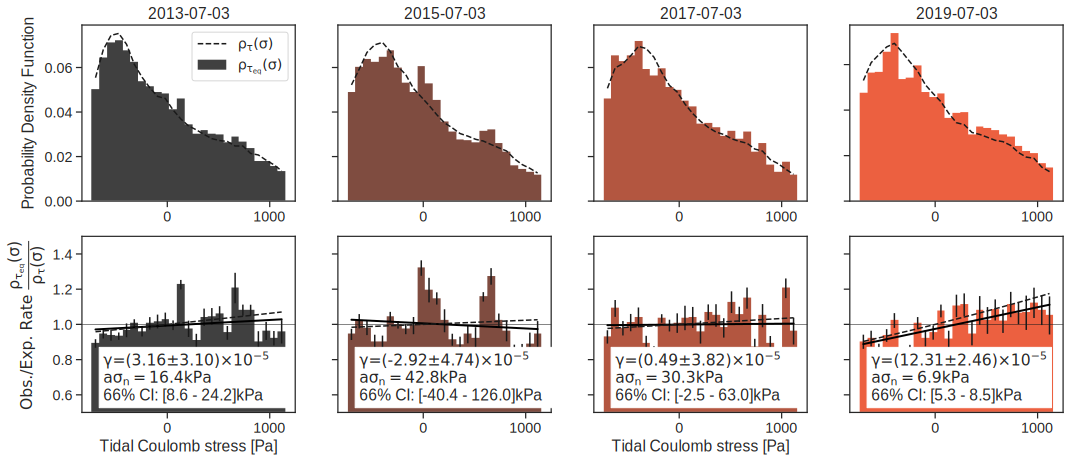

In [225]:
%matplotlib inline

ratio = "rate_ratio"
stress = "coulomb_stress"

fig, axes = plt.subplots(
    num=f"seismicity_and_tidal_stress",
    ncols=len(seismicity_vs_stress)-1,
    nrows=2,
    figsize=(15, 7),
)
plt.subplots_adjust(right=0.99, left=0.08)
# fig.suptitle(
#     "Seismicity rate vs. tidal Coulomb stress value",
#     fontsize=20,
# )

time_periods = list(seismicity_vs_stress.keys())
time_periods.sort()

bin_width = (
    seismicity_vs_stress[time_periods[0]][stress]["stress_bins"][1]
    - seismicity_vs_stress[time_periods[0]][stress]["stress_bins"][0]
)
barplot_params = {"edgecolor": "none", "align": "edge", "width": bin_width,"rasterized": True, "alpha": 0.75}

# color map for time stress
cnorm = Normalize(
    vmin=pd.Timestamp(time_periods[0]).timestamp(),
    vmax=pd.Timestamp(time_periods[-2]).timestamp(),
)
scalar_map = ScalarMappable(cmap=cc.cm.kr, norm=cnorm)

for i, key in enumerate(time_periods[:-1]):
    mid_bins = (
        seismicity_vs_stress[key][stress]["stress_bins"][1:]
        + seismicity_vs_stress[key][stress]["stress_bins"][:-1]
    ) / 2.
    color = scalar_map.to_rgba(pd.Timestamp(key).timestamp())
    axes[0, i].set_title(key)
    bin_width = (
        seismicity_vs_stress[key][stress]["stress_bins"][1]
        - seismicity_vs_stress[key][stress]["stress_bins"][0]
    )
    axes[0, i].bar(
        seismicity_vs_stress[key][stress]["stress_bins"][:-1],
        seismicity_vs_stress[key][stress]["observed_rate"],
        color=color,
        label=r"$\rho_{\tau_{eq}}(\sigma)$",
        **barplot_params,
    )
    axes[0, i].plot(
        mid_bins,
        seismicity_vs_stress[key][stress]["expected_rate"],
        color="k",
        ls="--",
        label=r"$\rho_{\tau}(\sigma)$",
    )
    selection = seismicity_vs_stress[key][stress][f"{ratio}_err"] < 1.
    axes[1, i].bar(
        seismicity_vs_stress[key][stress]["stress_bins"][:-1][selection],
        seismicity_vs_stress[key][stress][ratio][selection],
        yerr=seismicity_vs_stress[key][stress][f"{ratio}_err"][selection],
        color=color,
        # width=bin_width,
        **barplot_params,
    )
    axes[1, i].axhline(1., color="k", lw=0.50)
    # linear fit stress histogram
    intercept, slope, intercept_err, slope_err = seistides.fit_stress_hist_scipy(
        mid_bins[selection],
        seismicity_vs_stress[key][stress][ratio][selection],
        seismicity_vs_stress[key][stress][f"{ratio}_err"][selection],
    )
    fit = intercept + slope * mid_bins
    axes[1, i].plot(mid_bins, fit, lw=2, color="black")
    # test rate state model
    Asig_Pa, Asig_Pa_min, Asig_Pa_max = seistides.fit_rate_state(
        mid_bins[selection],
        seismicity_vs_stress[key][stress][ratio][selection],
        seismicity_vs_stress[key][stress][f"{ratio}_err"][selection]
    )
    fit = seistides.rate_state(mid_bins, Asig_Pa)
    slope *= 1.e5
    slope_err *= 1.e5
    if Asig_Pa/1e3 >= 150.:
        axes[1, i].text(
            0.10,
            0.05,
            r"$\gamma$=" f"({slope:.2f}" r"$\pm$" f"{slope_err:.2f})"r"$\times 10^{-5}$"
            f"\n"r"$a \sigma_n=$N/A",
            bbox={"facecolor": "white"},
            ha="left",
            va="bottom",
            transform=axes[1, i].transAxes,
        )
    else:
        axes[1, i].plot(mid_bins, fit, color="k", ls="--")
        axes[1, i].text(
            0.10,
            0.05,
            r"$\gamma$=" f"({slope:.2f}" r"$\pm$" f"{slope_err:.2f})"r"$\times 10^{-5}$"
            f"\n"r"$a \sigma_n=$"f"{Asig_Pa/1.e3:.1f}kPa\n66% CI: [{Asig_Pa_min/1.e3:.1f} - {Asig_Pa_max/1.e3:.1f}]kPa",
            bbox={"facecolor": "white"},
            ha="left",
            va="bottom",
            transform=axes[1, i].transAxes,
        )
    if i == 0:
        axes[0, i].legend(loc="upper right")

axes[0, 0].set_ylabel("Probability Density Function")
axes[1, 0].set_ylabel(r"Obs./Exp. Rate $\dfrac{\rho_{\tau_{eq}}(\sigma)}{\rho_{\tau}(\sigma)}$")
for ax in axes[1, ::2]:
    if stress[-4:] == "rate":
        ax.set_xlabel(f"Tidal {stress.replace('_', ' ').capitalize()} [Pa/s]")
    else:
        ax.set_xlabel(f"Tidal {stress.replace('_', ' ').capitalize()} [Pa]")

for i in range(1, axes.shape[1]):
    if i != axes.shape[1] - 1:
        axes[0, i].sharey(axes[0, 0])
    axes[1, i].sharey(axes[1, 0])
    plt.setp(axes[0, i].get_yticklabels(), visible=False)
    plt.setp(axes[1, i].get_yticklabels(), visible=False)

axes[1, 0].set_ylim(0.5, 1.5)

fig.set_facecolor("w")
fig._label += f"_{fortnightly_phase.split()[0]}"
print(fig._label)
